# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

project_folder = '/Users/dusiyi/Documents/Multifirefly-Project'
os.chdir(project_folder)
sys.path.append(os.path.join(project_folder, 'multiff_analysis', 'methods'))

from data_wrangling import specific_utils, process_monkey_information
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from non_behavioral_analysis.neural_data_analysis.get_neural_data import neural_data_processing
from non_behavioral_analysis.neural_data_analysis.visualize_neural_data import plot_neural_data, plot_modeling_result
from non_behavioral_analysis.neural_data_analysis.model_neural_data import cca_class, pgam_class, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from non_behavioral_analysis.neural_data_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from non_behavioral_analysis.neural_data_analysis.planning_neural import planning_neural_class, planning_neural_utils
from non_behavioral_analysis.neural_data_analysis.decode_targets import behav_features_to_keep, decode_target_class

import sys
import math
import gc
import subprocess
from pathlib import Path
from importlib import reload

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")

%load_ext autoreload
%autoreload 2

done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

In [2]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"
dec = decode_target_class.DecodeTargetClass(raw_data_folder_path=raw_data_folder_path,
                                                               bin_width=0.1, window_width=0.25)
dec.streamline_making_behav_and_neural_data()
dec.get_x_and_y_var()

dec.pursuit_data.head(3)


Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Schro/data_0416/ff_dataframe.h5
Retrieved target_df
Warnings: At least one ff has a lower bound equal to the upper bound. Please check the input.
Retrieved target_clust_last_vis_df
Percentage of targets not in a visible cluster out of all targets 65.1063829787234
2248 rows of 35989 rows (6.2%) of behav_data_all are preserved after taking out chunks between target last-seen time and capture time
Window width changed from 0.25 to 0.3 to make it odd


,bin,point_index,monkey_speed,monkey_angle,monkey_dw,monkey_ddw,monkey_ddv,monkey_speeddummy,whether_new_distinct_stop,delta_distance,...,monkey_x,monkey_y,cum_distance,gaze_world_x_l,gaze_world_y_l,gaze_world_x_r,gaze_world_y_r,target_index,target_x,target_y
156,156,940,41.00465,1.33400,0.00011,-0.00402,-13.40594,1,False,0.68236,...,155.21442,321.85620,569.56511,235.04676,626.74730,189.47658,492.20289,0,176.86879,473.79919
157,157,946,0.00000,1.32465,-0.52076,0.01692,0.00000,0,False,0.00000,...,155.22058,321.88010,569.72627,180.84873,402.80068,173.38897,386.30916,0,176.86879,473.79919
158,158,952,0.00000,1.32482,0.00000,0.00265,0.00000,0,False,0.00000,...,155.22058,321.88010,569.72627,183.45252,410.29222,174.76972,391.08507,0,176.86879,473.79919


# plot

In [14]:
dec.single_vis_ff_targets

,target_index,last_vis_point_index,last_vis_ff_index,nearby_vis_ff_indices,time_since_last_vis,last_vis_dist,last_vis_cum_dist,last_vis_ang,last_vis_ang_to_bndry,last_vis_target_dist,last_vis_target_ang,last_vis_target_ang_to_bndry,abs_last_vis_ang,abs_last_vis_ang_to_bndry,abs_last_vis_target_ang,abs_last_vis_target_ang_to_bndry,nearby_alive_ff_indices,num_nearby_vis_ff,ff_caught_time,ff_caught_point_index
0,0,938,89,[89],1.37780,172.81621,159.53610,0.17256,0.11467,22.16196,0.09453,0.00000,0.17256,0.11467,0.09453,0.00000,[ 0 89],1,17.07656,1021
1,1,1392,1,[1],1.79291,244.05748,240.22906,-0.42981,-0.38882,0.00000,-0.42981,0.00000,0.42981,0.38882,0.42981,0.00000,[1],1,25.01125,1500
2,2,1669,2,[2],1.62689,124.07438,117.12410,0.11515,0.03447,0.00000,0.11515,0.00000,0.11515,0.03447,0.11515,0.00000,[2],1,29.41040,1767
9,9,3062,9,[9],0.18283,10.31403,19.12691,1.81376,0.49036,0.00000,1.81376,0.00000,1.81376,0.49036,1.81376,0.00000,[9],1,50.94039,3073
11,11,3431,11,[11],0.16622,26.26680,20.68853,0.76851,0.37795,0.00000,0.76851,0.00000,0.76851,0.37795,0.76851,0.00000,[11],1,56.98268,3441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,465,144752,465,[465],1.16209,148.90947,132.24456,-0.08097,-0.01376,0.00000,-0.08097,0.00000,0.08097,0.01376,0.08097,0.00000,[465],1,2397.75680,144822
466,466,155989,466,[466],1.46076,162.53028,168.86867,-0.05365,-0.00000,0.00000,-0.05365,0.00000,0.05365,0.00000,0.05365,0.00000,[466],1,2584.57109,156077
467,467,216701,467,[467],0.79687,81.03235,110.01555,0.07105,0.00000,0.00000,0.07105,0.00000,0.07105,0.00000,0.07105,0.00000,[467 612],1,3591.69901,216750
468,468,217049,468,[468],0.89655,125.11175,122.27554,-0.26022,-0.18020,0.00000,-0.26022,0.00000,0.26022,0.18020,0.26022,0.00000,[468],1,3597.54221,217103


In [15]:
from visualization.matplotlib_tools import plot_trials, monkey_heading_functions

In [19]:
dec.make_PlotTrials_args()

In [24]:
row

target_index                               0
last_vis_point_index                     938
last_vis_ff_index                         89
nearby_vis_ff_indices                   [89]
time_since_last_vis                  1.37780
last_vis_dist                      172.81621
last_vis_cum_dist                  159.53610
last_vis_ang                         0.17256
last_vis_ang_to_bndry                0.11467
last_vis_target_dist                22.16196
last_vis_target_ang                  0.09453
last_vis_target_ang_to_bndry         0.00000
abs_last_vis_ang                     0.17256
abs_last_vis_ang_to_bndry            0.11467
abs_last_vis_target_ang              0.09453
abs_last_vis_target_ang_to_bndry     0.00000
nearby_alive_ff_indices              [ 0 89]
num_nearby_vis_ff                          1
ff_caught_time                      17.07656
ff_caught_point_index                   1021
Name: 0, dtype: object

In [33]:
dec.single_vis_ff_targets['last_vis_time'] = dec.monkey_information.loc[dec.single_vis_ff_targets['last_vis_point_index'].values, 'time'].values

/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_9873/2335818842.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dec.single_vis_ff_targets['last_vis_time'] = dec.monkey_information.loc[dec.single_vis_ff_targets['last_vis_point_index'].values, 'time'].values


currentTrial: 60 num_trials: 1


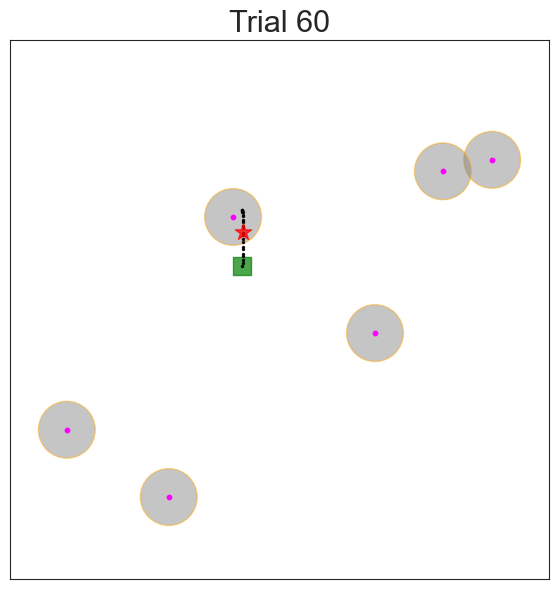

currentTrial: 61 num_trials: 1


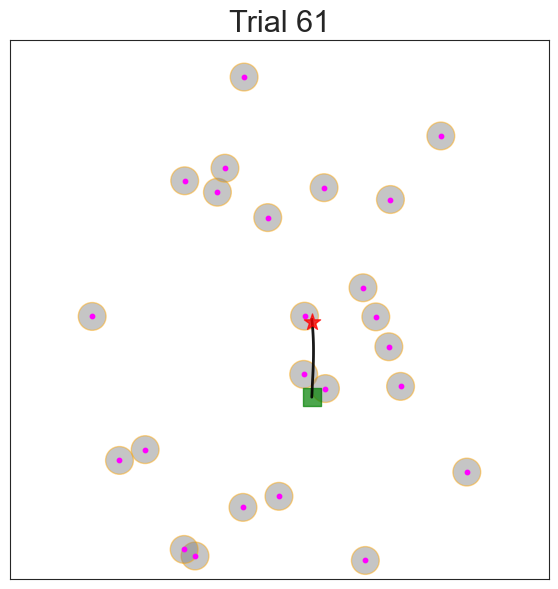

currentTrial: 62 num_trials: 1


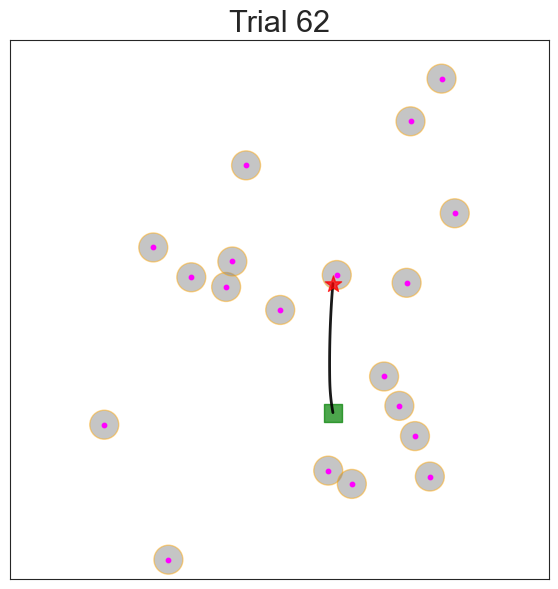

currentTrial: 63 num_trials: 1


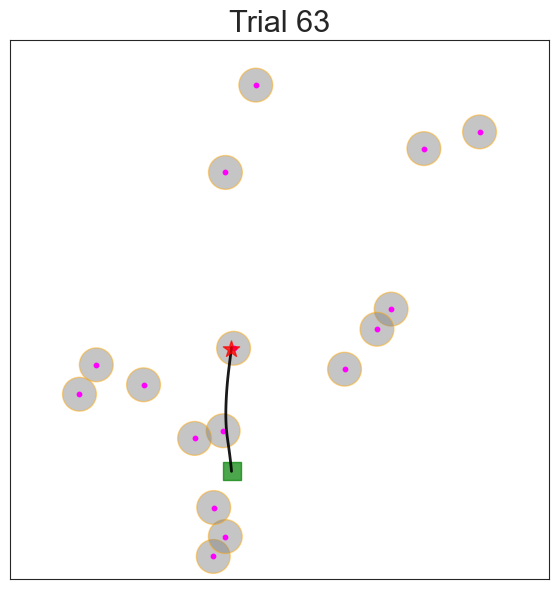

currentTrial: 64 num_trials: 1


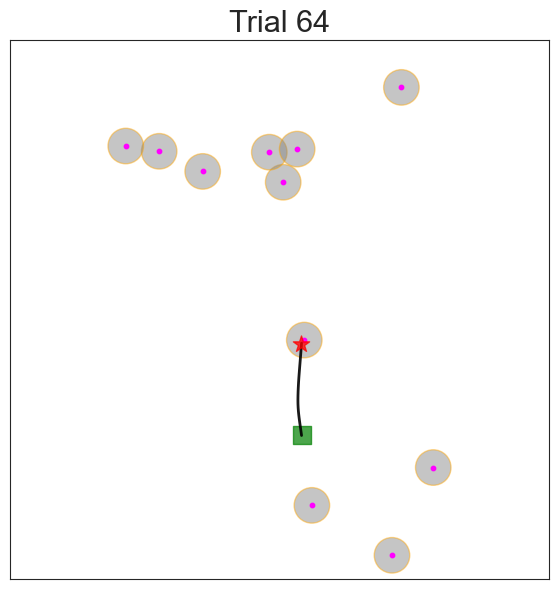

currentTrial: 65 num_trials: 1


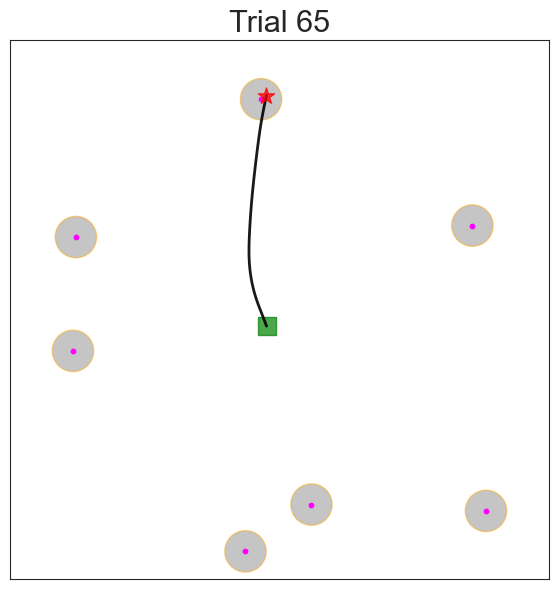

currentTrial: 67 num_trials: 1


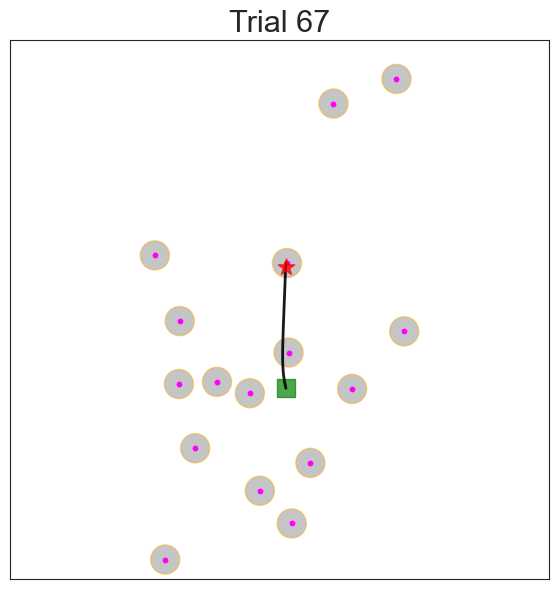

currentTrial: 68 num_trials: 1


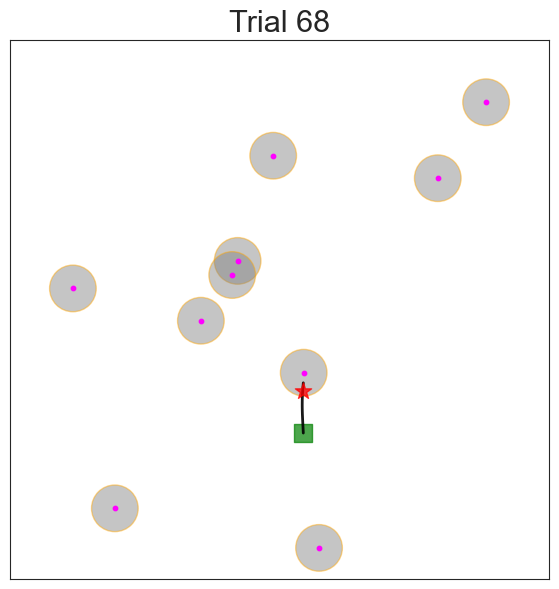

currentTrial: 69 num_trials: 1


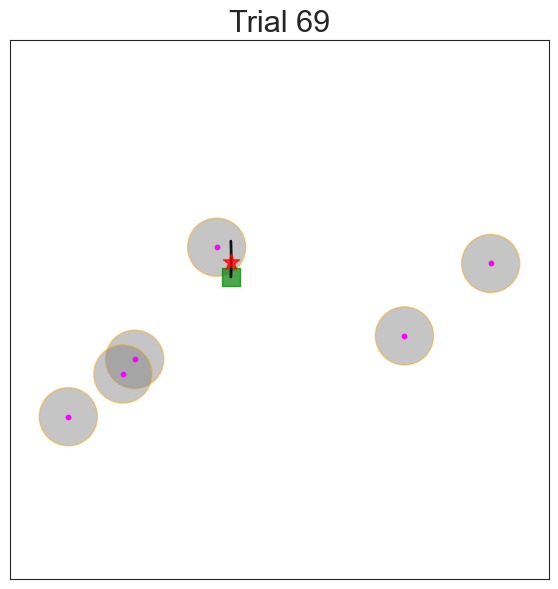

currentTrial: 70 num_trials: 1


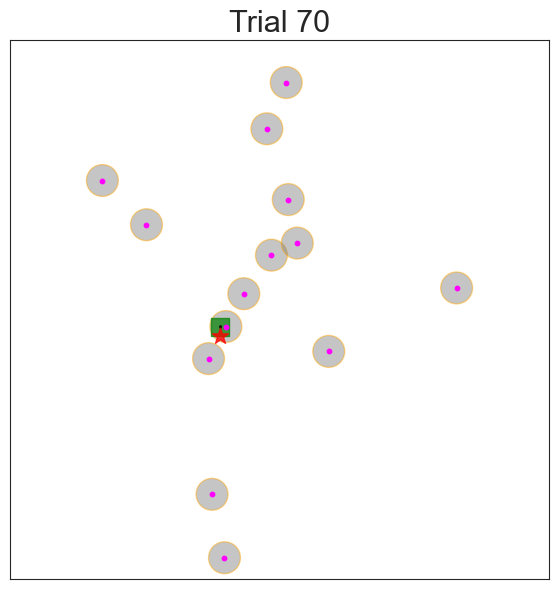

In [66]:
plt.rcParams['figure.figsize'] = [10, 10]                     

max_plot_to_make = 10
plot_counter = 0

for index, row in dec.single_vis_ff_targets.iloc[30:].iterrows():

    duration = [row['last_vis_time'], row['ff_caught_time']]

    returned_info = plot_trials.PlotTrials(
                duration, 
                *dec.PlotTrials_args,  
                adjust_xy_limits=True,       
                minimal_margin=50,
                show_reward_boundary=True,
                show_alive_fireflies=False,
                show_visible_fireflies=True,
                show_in_memory_fireflies=True,
                show_believed_target_positions=True,
                )
    plt.show()
    

    plot_counter += 1
    if plot_counter >= max_plot_to_make:
        break

# now, check target x and y

In [ ]:
dec.target_df['target_rel_y'] = dec.target_df['target_distance'] * np.cos(dec.target_df['target_angle'])
dec.target_df['target_rel_x'] = - dec.target_df['target_distance'] * np.sin(dec.target_df['target_angle'])

In [ ]:
dec.pursuit_data['target_rel_y'] = dec.pursuit_data['target_distance'] * np.cos(dec.pursuit_data['target_angle'])
dec.pursuit_data['target_rel_x'] = - dec.pursuit_data['target_distance'] * np.sin(dec.pursuit_data['target_angle'])


In [67]:
pursuit_sub = dec.pursuit_data.loc[dec.pursuit_data['target_index']==65]
pursuit_sub['target_angle_deg'] = pursuit_sub['target_angle'] * 180/pi 

/var/folders/81/249hbjx960s5t_1dxgdxz6r00000gn/T/ipykernel_9873/1694228688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pursuit_sub['target_angle_deg'] = pursuit_sub['target_angle'] * 180/pi


In [51]:
row['last_vis_point_index']

1392

In [68]:
pursuit_sub[['point_index', 'target_angle_deg', 'target_distance', 'target_rel_x', 'target_rel_y']]

,point_index,target_angle_deg,target_distance,target_rel_x,target_rel_y
2737,16581,-19.08358,273.65073,89.46931,258.61161
2738,16587,-21.24098,256.37906,92.88390,238.96193
2739,16593,-19.21783,240.56301,79.18384,227.15739
2740,16599,-15.48348,227.39748,60.70615,219.14465
2741,16605,-11.07262,211.40981,40.60188,207.47433
2742,16611,-7.07089,193.13773,23.77473,191.66885
2743,16617,-3.57020,175.26667,10.91410,174.92652
2744,16623,-1.90696,156.51957,5.20844,156.43289
2745,16629,-1.03773,137.56351,2.49138,137.54095
2746,16635,-0.08741,118.52200,0.18082,118.52186


# Reduce columns in lags

In [6]:
dec.reduce_x_var_lags()


====================Dropping lags of features with high correlation for each feature====================
Processing feature 1/86
Processing feature 11/86
Processing feature 21/86
Processing feature 31/86
Processing feature 41/86
Processing feature 51/86
Processing feature 61/86
Processing feature 71/86
Processing feature 81/86

0 out of 946 (0.00%) are dropped after dropping lags of features with high correlation for each feature

** Summary: 0 out of 946 (0.00%) are dropped after calling drop_columns_with_high_corr. **


In [13]:
dec.reduce_y_var_lags()


====================Dropping lags of features with high correlation for each feature====================
Processing feature 1/54
10 columns of *bin* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
10 columns of *monkey_angle* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *monkey_speeddummy* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
Processing feature 11/54
Processing feature 21/54
9 columns of *valid_view_point_r* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
10 columns of *num_alive_ff* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *min_ff_distance* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
10 columns of *min_abs_ff_angle* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
10 columns of *min_abs_ff_angle_boundary* dropped: [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *min_abs_visible_ff_angle* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
9 columns of *min_abs_visible_ff_angle_boundary* dropped: [-4, -3, -2, -1, 0, 1, 2, 3, 4]
Processing feature 31/54
9 columns of *target_dist

## check result of reducing

In [15]:
## also check correlations between x vars without lags
high_corr_pair_df, top_n_corr_df = drop_high_corr_vars.get_pairs_of_columns_w_high_corr(
            dec.x_var, corr_threshold=0.8)
top_n_corr_df

,var_1,var_2,corr,abs_corr
0,unit_64,unit_65,0.58138,0.58138
1,unit_52,unit_53,0.55588,0.55588
2,unit_51,unit_53,0.51038,0.51038
3,unit_21,unit_75,0.50674,0.50674
4,unit_4,unit_31,0.46924,0.46924


## regression

In [133]:
[col for col in dec.y_var_lags_reduced.columns if 'bin' in col]

['bin_5']

In [138]:
dec.y_var_lags_reduced['bin'] = dec.y_var_lags_reduced['bin_5']

In [139]:
dec.y_var_lags_reduced['bin']

0           0.00000
1           0.00000
2           0.00000
3           0.00000
4           0.00000
            ...    
35984   35979.00000
35985   35980.00000
35986   35981.00000
35987   35982.00000
35988   35983.00000
Name: bin, Length: 35989, dtype: float64

In [142]:
dec.y_var_lags_reduced['bin'] = dec.y_var_lags_reduced['bin_5'].astype(int)

In [144]:
dec.y_var_lags_reduced

,monkey_speed_0,monkey_dw_0,monkey_ddw_0,monkey_ddv_0,monkey_speeddummy_0,whether_new_distinct_stop_0,delta_distance_0,LDz_0,RDz_0,gaze_mky_view_x_l_0,gaze_mky_view_y_l_0,gaze_mky_view_angle_l_0,gaze_mky_view_x_r_0,gaze_mky_view_y_r_0,gaze_mky_view_angle_r_0,eye_world_speed_0,valid_view_point_l_0,valid_view_point_r_0,num_visible_ff_0,min_visible_ff_distance_0,min_abs_visible_ff_angle_0,catching_ff_0,any_ff_visible_0,target_visible_dummy_0,traj_curv_0,gaze_world_x_l_0,gaze_world_y_l_0,gaze_world_x_r_0,gaze_world_y_r_0,monkey_speed_-1,monkey_dw_-1,monkey_ddw_-1,monkey_ddv_-1,monkey_speeddummy_-1,whether_new_distinct_stop_-1,delta_distance_-1,LDz_-1,RDz_-1,gaze_mky_view_x_l_-1,gaze_mky_view_y_l_-1,gaze_mky_view_angle_l_-1,gaze_mky_view_x_r_-1,gaze_mky_view_y_r_-1,gaze_mky_view_angle_r_-1,eye_world_speed_-1,valid_view_point_l_-1,valid_view_point_r_-1,num_visible_ff_-1,min_visible_ff_distance_-1,min_abs_visible_ff_angle_-1,...,target_opt_arc_dheading_-5,gaze_world_x_l_-5,gaze_world_y_l_-5,gaze_world_x_r_-5,gaze_world_y_r_-5,bin_5,monkey_speed_5,monkey_angle_5,monkey_dw_5,monkey_ddw_5,monkey_ddv_5,monkey_speeddummy_5,whether_new_distinct_stop_5,delta_distance_5,LDz_5,RDz_5,gaze_mky_view_x_l_5,gaze_mky_view_y_l_5,gaze_mky_view_angle_l_5,gaze_mky_view_x_r_5,gaze_mky_view_y_r_5,gaze_mky_view_angle_r_5,eye_world_speed_5,valid_view_point_l_5,valid_view_point_r_5,num_alive_ff_5,num_visible_ff_5,min_ff_distance_5,min_abs_ff_angle_boundary_5,min_visible_ff_distance_5,min_abs_visible_ff_angle_boundary_5,catching_ff_5,any_ff_visible_5,target_distance_5,target_angle_to_boundary_5,target_last_seen_distance_frozen_5,target_last_seen_angle_to_boundary_frozen_5,target_visible_dummy_5,time_since_last_capture_5,traj_curv_5,target_opt_arc_dheading_5,monkey_x_5,monkey_y_5,gaze_world_x_l_5,gaze_world_y_l_5,gaze_world_x_r_5,gaze_world_y_r_5,target_x_5,target_y_5,bin
0,0.00000,188.45962,0.00000,0.00000,0.00000,1.00000,0.00000,-9.46805,-16.34467,23.01669,54.72201,-0.39815,14.68699,31.44551,-0.43695,2.90217,1.00000,1.00000,3.00000,295.62093,-0.34977,0.00000,1.00000,0.00000,-0.00000,23.01669,87.22201,14.68699,63.94551,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-10.03339,-12.25394,21.61105,51.57920,-0.39677,18.73310,42.69521,-0.41347,27.55411,1.00000,1.00000,2.00000,295.62093,-0.34977,...,0.00000,-12.44882,12.58316,-17.70399,23.51698,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-10.03339,-12.25394,21.61105,51.57920,-0.39677,18.73310,42.69521,-0.41347,27.55411,1.00000,1.00000,2.00000,295.62093,-0.34977,0.00000,1.00000,0.00000,-0.00000,-22.17204,-18.84055,-19.19742,-9.98846,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-9.83624,-11.88864,21.80957,52.75621,-0.39201,18.85306,44.21683,-0.40304,12.73637,1.00000,1.00000,2.00000,295.62093,-0.34977,...,0.00000,-14.01808,9.81219,-15.53883,18.15337,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-9.83624,-11.88864,21.80957,52.75621,-0.39201,18.85306,44.21683,-0.40304,12.73637,1.00000,1.00000,2.00000,295.62093,-0.34977,0.00000,1.00000,0.00000,-0.00000,-22.38338,-20.01532,-19.33395,-11.50868,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-9.84494,-12.13217,21.72716,52.73576,-0.39081,18.53133,43.28849,-0.40448,19.11256,1.00000,1.00000,3.00000,295.62093,-0.55053,...,0.00000,

In [ ]:
# conduct linear regression on X and y
plt.rcParams["figure.figsize"] = (20, 10)
bins_to_plot = range(dec.y_var_lags_reduced.bin.max())
dec.y_var_lags_reduced['bin'] = dec.y_var_lags_reduced['bin_5'].astype(int)
for i, column in enumerate(dec.y_var_lags_reduced.columns):

    
    plot_neural_data.plot_regression(dec.y_var_lags_reduced, column, dec.x_var, bins_to_plot=None, min_r_squared_to_plot=0.3)
    # if i == 3:
    #     break

ValueError: Found input variables with inconsistent numbers of samples: [2248, 35989]

# just to compare: from neural_data_modeling

In [145]:
data_item = neural_vs_behavioral_class.NeuralVsBehavioralClass(raw_data_folder_path=raw_data_folder_path)
data_item.streamline_preparing_neural_and_behavioral_data()

Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
Note: ff_caught_T_sorted is replaced with ff_caught_T_new
Retrieved ff_dataframe from all_monkey_data/processed_data/monkey_Schro/data_0416/ff_dataframe.h5
When take out monkey subset for GUAT, 144 clusters out of 254 are too close to the target or the last target. Those clusters are filtered out.
The number of new trials that are used to separate stop clusters is 470
Retrieved all_trial_patterns
Retrieved pattern_frequencies
Retrieved all_trial_features
Retrieved feature_statistics
Retrieved scatter_around_target_df
Window width changed from 0.25 to 0.3 to make it odd
Retrieved target_df
Calculating target-cluster-last-seen info.
Adding last seen info: target_index = 469
Made new target_cluster_df


In [147]:
data_item.final_behavioral_data

,bin,num_alive_ff,num_visible_ff,min_ff_distance,min_abs_ff_angle,min_visible_ff_distance,min_abs_visible_ff_angle,catching_ff,any_ff_visible,LDy,LDz,RDy,RDz,gaze_mky_view_x,gaze_mky_view_y,gaze_world_x,gaze_world_y,monkey_speed,monkey_angle,monkey_dw,monkey_ddw,monkey_ddv,num_distinct_stops,num_caught_ff,stop_rate,stop_success_rate,avg_target_distance,avg_target_angle,avg_target_last_seen_time,avg_target_last_seen_distance_frozen,avg_target_last_seen_angle_frozen,avg_target_cluster_last_seen_distance_frozen,avg_target_cluster_last_seen_angle_frozen,min_target_has_disappeared_for_last_time_dummy,min_target_cluster_has_disappeared_for_last_time_dummy,max_target_visible_dummy,max_target_cluster_visible_dummy,try_a_few_times_indice_dummy,give_up_after_trying_indice_dummy,ignore_sudden_flash_indice_dummy,two_in_a_row,visible_before_last_one,disappear_latest,ignore_sudden_flash,try_a_few_times,give_up_after_trying,cluster_around_target,waste_cluster_around_target
0,0,3.00000,3.00000,295.62093,-2.89714,295.62093,-0.34977,0,1,23.78424,-9.46805,21.78357,-16.34467,18.85184,43.08376,18.85184,75.58376,0.00000,1.57080,188.45962,0.00000,0.00000,1.00000,0.00000,3.33333,0.00000,475.42354,-0.38119,100.00000,400.00000,0.00000,400.00000,0.00000,0,0,0,0,0,0,0,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
1,1,3.00000,2.00000,295.62093,-2.89714,295.62093,-0.34977,0,1,23.74365,-10.03339,21.45459,-12.25394,20.17208,47.13721,-20.68473,-14.41451,0.00000,-1.58170,0.00000,0.00000,0.00000,0.00000,0.00000,3.33333,0.00000,475.42354,2.77131,100.00000,400.00000,0.00000,400.00000,0.00000,0,0,0,0,0,0,0,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
2,2,3.00000,2.00000,295.62093,-2.89714,295.62093,-0.34977,0,1,23.46594,-9.83624,20.94617,-11.88864,20.33131,48.48652,-20.85866,-15.76200,0.00000,-1.58170,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,475.42354,2.77131,100.00000,400.00000,0.00000,400.00000,0.00000,0,0,0,0,0,0,0,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
3,3,4.00000,3.00000,295.62093,-2.89714,295.62093,-0.55053,0,1,23.39972,-9.84494,20.97394,-12.13217,20.12924,48.01213,-20.65143,-15.28984,0.00000,-1.58170,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,475.42354,2.77131,100.00000,400.00000,0.00000,400.00000,0.00000,0,0,0,0,0,0,0,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
4,4,4.00000,2.00000,295.62093,-2.89714,368.11133,-0.55053,0,1,23.33350,-10.02759,21.03375,-12.19885,19.86656,47.40092,-20.38210,-14.68153,0.00000,-1.58170,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,475.42354,2.77131,100.00000,400.00000,0.00000,400.00000,0.00000,0,0,0,0,0,0,0,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35983,35983,2.00000,1.00000,31.31565,-2.72764,31.31565,0.47921,0,1,16.40997,-11.55545,132.99573,-9.17212,29.99387,2.61761,-951.89157,-66.17121,49.10378,-2.60634,0.82007,-0.15804,51.87774,0.00000,0.00000,0.00000,0.00000,67.21404,0.28942,1229.43243,142.18819,-0.16221,42.91577,0.47921,1,0,0,1,0,0,0,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
35984,35984,2.00000,1.00000,19.26706,-2.85592,19.26706,0.59846,0,1,15.91437,-10.14355,132.99573,-7.75732,34.87825,2.07905,-968.96672,-71.57990,76.12356,-2.51344,0.57436,-0.65533,20.41281,0.00000,0.00000,0.00000,0.00000,53.06443,0.26720,1229.53211,142.18819,-0.16221,30.27592,0.59846,1,0,0,1,0,0,0,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
35985,35985,2.00000,1.00000,15.09003,-2.97227,16.54559,1.04301,0,1,16.19421,-15.36496,132.99573,-193.99420,20.38550,4.23441,-977.38306,-97.33117,161.95553,-2.40967,1.06698,0.00477,0.75798,0.00000,0.00000,0.00000,0.00000,35.97721,0.27076,1229.63176,142.18819,-0.16221,17.78233,1.04301,1,0,0,1,0,0,0,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1

In [146]:
data_item.y_var

,bin,num_alive_ff,num_visible_ff,min_ff_distance,min_abs_ff_angle,min_visible_ff_distance,min_abs_visible_ff_angle,catching_ff,any_ff_visible,LDy,LDz,RDy,RDz,gaze_mky_view_x,gaze_mky_view_y,gaze_world_x,gaze_world_y,monkey_speed,monkey_angle,monkey_dw,monkey_ddw,monkey_ddv,num_distinct_stops,num_caught_ff,stop_rate,stop_success_rate,avg_target_distance,avg_target_angle,avg_target_last_seen_time,avg_target_last_seen_distance_frozen,avg_target_last_seen_angle_frozen,avg_target_cluster_last_seen_distance_frozen,avg_target_cluster_last_seen_angle_frozen,min_target_has_disappeared_for_last_time_dummy,min_target_cluster_has_disappeared_for_last_time_dummy,max_target_visible_dummy,max_target_cluster_visible_dummy,try_a_few_times_indice_dummy,give_up_after_trying_indice_dummy,ignore_sudden_flash_indice_dummy,two_in_a_row,visible_before_last_one,disappear_latest,ignore_sudden_flash,try_a_few_times,give_up_after_trying,cluster_around_target,waste_cluster_around_target
0,169,11.00000,1.00000,22.42811,-2.61119,396.62824,0.38492,1,0,2.48602,-8.52292,-0.48450,-10.29120,1.22671,60.86862,193.99646,537.33503,12.04708,1.39691,0.00000,0.00000,-3.39544,0.00000,1.00000,0.00000,0.00000,6.59198,2.35859,100.00000,400.00000,0.00000,172.81621,0.17256,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
1,170,11.00000,1.00000,22.42811,-2.61119,390.99539,0.41246,0,1,2.72955,-7.67346,-0.31787,-10.20422,1.62664,64.84402,195.08908,541.24332,0.00000,1.39691,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,666.46795,-1.66321,100.00000,400.00000,0.00000,400.00000,0.00000,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
2,171,11.00000,1.00000,22.42811,-2.61293,390.99539,0.41073,0,1,2.69965,-7.76334,-0.17688,-10.17813,1.65605,64.48364,195.05569,540.88329,0.00000,1.39691,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,666.46795,-1.66321,100.00000,400.00000,0.00000,400.00000,0.00000,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
3,172,11.00000,1.00000,22.42811,-2.61707,390.99539,0.40659,0,1,2.69324,-7.95178,-0.16833,-10.38397,1.61680,63.04081,194.65098,539.49244,0.00000,1.39879,0.00964,-0.00745,0.00000,0.00000,0.00000,0.00000,0.00000,666.46795,-1.66509,100.00000,400.00000,0.00000,400.00000,0.00000,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
4,173,12.00000,2.00000,22.42811,-2.61707,320.54000,-0.67041,0,1,2.75946,-7.94598,-0.09998,-10.47675,1.69331,62.81830,194.44251,539.30916,0.00000,1.40278,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,666.46795,-1.66908,100.00000,400.00000,0.00000,400.00000,0.00000,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23802,23971,8.00000,3.00000,33.84642,-2.57497,229.05367,-0.73235,0,1,0.74500,-3.77988,-4.20367,-5.24374,-3.02411,130.00622,710.01296,-160.39503,77.39581,-1.54885,-0.00009,-0.00055,0.00000,0.00000,0.00000,0.00000,0.00000,46.97004,-0.05517,0.64742,148.90947,-0.08097,148.90947,-0.08097,1,1,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
23803,23972,8.00000,3.00000,22.36591,-2.62830,309.52299,-0.55407,0,1,1.21069,-4.12488,-3.34491,-5.51047,-1.56930,121.05452,710.24945,-168.36044,200.00000,-1.53676,0.25985,-0.02476,-2.38467,0.00000,0.00000,0.00000,0.00000,30.06680,-0.10011,0.74714,148.90947,-0.08097,148.90947,-0.08097,1,1,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000
23804,23973,8.00000,3.00000,18.00822,-2.64981,305.15503,-0.56355,0,1,1.16797,-4.52786,-3.30219,-5.66412,-1.62713,113.45366,712.72759,-169.91133,91.86042,-1.51670,0.03566,0.06322,-6.18458,0.00000,0.00000,0.00000,0.00000,20.85661,-0.16904,0.84668,148.90947,-0.08097,148.90947,-0.08097,1,1,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.000

In [ ]:
dec.y_var_reduced

,bin,monkey_speed,monkey_angle,monkey_dw,monkey_ddw,monkey_ddv,monkey_speeddummy,whether_new_distinct_stop,delta_distance,LDy,LDz,RDy,RDz,gaze_mky_view_x_l,gaze_mky_view_y_l,gaze_mky_view_angle_l,gaze_mky_view_x_r,gaze_mky_view_y_r,gaze_mky_view_angle_r,eye_world_speed,valid_view_point_l,valid_view_point_r,num_alive_ff,num_visible_ff,min_ff_distance,min_abs_ff_angle,min_abs_ff_angle_boundary,min_visible_ff_distance,min_abs_visible_ff_angle,min_abs_visible_ff_angle_boundary,catching_ff,any_ff_visible,target_distance,target_angle,target_angle_to_boundary,target_last_seen_time,target_last_seen_distance_frozen,target_last_seen_angle_frozen,target_last_seen_angle_to_boundary_frozen,target_visible_dummy,time_since_last_capture,traj_curv,target_opt_arc_dheading,monkey_x,monkey_y,gaze_world_x_l,gaze_world_y_l,gaze_world_x_r,gaze_world_y_r,target_x,target_y
0,156,41.00465,1.33400,0.00011,-0.00402,-13.40594,1,0,0.68236,1.37732,-1.81714,-2.68481,-3.29260,6.08015,315.11081,-0.01929,-6.65558,173.63062,0.03831,1475.93381,1,1,15.00000,1.00000,30.88639,-2.90449,-2.88646,297.51210,-0.24793,-0.21432,0,1,153.47828,0.09523,0.03003,100.00000,400.00000,0.00000,0.00000,0,15.73202,0.00021,0.03154,155.21442,321.85620,235.04676,626.74730,189.47658,492.20289,176.86879,473.79919
1,157,0.00000,1.32465,-0.52076,0.01692,0.00000,0,0,0.00000,4.44922,-6.71094,0.35718,-8.49951,5.13831,84.72627,-0.06057,1.92178,66.91413,-0.02871,36.76910,1,1,15.00000,1.00000,30.90155,-2.89537,-2.87734,297.57850,-0.23879,-0.20518,0,1,153.45376,0.10460,0.03938,100.00000,400.00000,0.00000,0.00000,0,15.83158,0.00021,0.03151,155.22058,321.88010,180.84873,402.80068,173.38897,386.30916,176.86879,473.79919
2,158,0.00000,1.32482,0.00000,0.00265,0.00000,0,0,0.00000,4.51331,-6.14270,0.48108,-7.91968,5.85391,92.62547,-0.06312,2.10938,71.88218,-0.02934,139.61149,1,1,14.00000,1.00000,30.90155,-2.90198,-2.88404,294.94761,-0.24635,-0.21244,0,1,153.45376,0.10443,0.03921,100.00000,400.00000,0.00000,0.00000,0,15.93114,0.00021,0.03151,155.22058,321.88010,183.45252,410.29222,174.76972,391.08507,176.86879,473.79919
3,159,96.65374,1.33351,0.19151,-0.06877,-10.32084,1,0,1.60735,4.51758,-6.14850,0.74597,-8.14001,5.85395,92.53689,-0.06318,2.41949,69.90756,-0.03460,79.56082,1,1,15.00000,1.00000,33.70633,-2.93474,-2.91722,465.42343,0.38432,0.36283,0,1,149.16448,0.09878,0.03169,100.00000,400.00000,0.00000,0.00000,0,16.03073,0.00044,0.06555,156.27438,326.06323,183.71659,414.63111,175.05898,393.44319,176.86879,473.79919
4,160,164.74027,1.36759,0.59110,-0.10250,-37.48671,1,0,2.74012,4.09888,-6.70514,0.52380,-8.01245,4.62179,84.83952,-0.05442,2.15586,71.03865,-0.03034,149.83044,1,1,14.00000,1.00000,44.84433,-2.97357,-2.95654,449.76995,0.36347,0.34143,0,1,134.58825,0.07389,0.00000,100.00000,400.00000,0.00000,0.00000,0,16.13037,0.00115,0.15551,159.51276,340.33472,181.16127,422.49582,175.96087,409.47657,176.86879,473.79919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,35971,200.00000,-2.63856,-0.22986,-0.22558,-0.07399,1,0,3.82641,-8.43652,1.97208,-12.57129,-5.52206,-44.13390,287.27417,0.15244,-21.11834,100.93319,0.20626,170.18107,0,1,8.00000,1.00000,25.18179,-2.96832,-2.94494,125.11175,-0.26022,-0.18020,0,0,36.36866,-0.41723,-0.13868,0.59764,125.11175,-0.26022,-0.18020,0,5.54429,-0.00229,-0.07853,-902.60120,-74.38060,-1133.01316,-251.53752,-980.85052,-141.54112,-938.83607,-77.49717
2244,35972,152.16557,-2.68061,-0.33010,0.09987,-40.10329,1,0,2.53036,-8.41730,-3.88425,-11.85779,-6.80640,-23.10903,145.68819,0.15731,-15.83819,81.96934,0.19087,170.18107,0,1,8.00000,1.00000,16.82730,-2.93353,-2.91136,125.11175,-0.26022,-0.18020,0,0,23.09596,-0.62896,-0.18117,0.69728,125.11175,-0.26022,-0.18020,0,5.64394,0.00067,-0.00002,-916.06519,-81.35854,-1036.26600,-166.86200,-982.43278,-132.00598,-938.83607,-77.49717
2245,35973,129.49627,-2.68299,0.06935,0.02028,-6.

In [154]:
data_item.y_var.columns

Index(['bin', 'num_alive_ff', 'num_visible_ff', 'min_ff_distance',
       'min_abs_ff_angle', 'min_visible_ff_distance',
       'min_abs_visible_ff_angle', 'catching_ff', 'any_ff_visible', 'LDy',
       'LDz', 'RDy', 'RDz', 'gaze_mky_view_x', 'gaze_mky_view_y',
       'gaze_world_x', 'gaze_world_y', 'monkey_speed', 'monkey_angle',
       'monkey_dw', 'monkey_ddw', 'monkey_ddv', 'num_distinct_stops',
       'num_caught_ff', 'stop_rate', 'stop_success_rate',
       'avg_target_distance', 'avg_target_angle', 'avg_target_last_seen_time',
       'avg_target_last_seen_distance_frozen',
       'avg_target_last_seen_angle_frozen',
       'avg_target_cluster_last_seen_distance_frozen',
       'avg_target_cluster_last_seen_angle_frozen',
       'min_target_has_disappeared_for_last_time_dummy',
       'min_target_cluster_has_disappeared_for_last_time_dummy',
       'max_target_visible_dummy', 'max_target_cluster_visible_dummy',
       'try_a_few_times_indice_dummy', 'give_up_after_trying_indice_d

In [151]:
dec.y_var_reduced.columns

Index(['bin', 'monkey_speed', 'monkey_angle', 'monkey_dw', 'monkey_ddw',
       'monkey_ddv', 'monkey_speeddummy', 'whether_new_distinct_stop',
       'delta_distance', 'LDy', 'LDz', 'RDy', 'RDz', 'gaze_mky_view_x_l',
       'gaze_mky_view_y_l', 'gaze_mky_view_angle_l', 'gaze_mky_view_x_r',
       'gaze_mky_view_y_r', 'gaze_mky_view_angle_r', 'eye_world_speed',
       'valid_view_point_l', 'valid_view_point_r', 'num_alive_ff',
       'num_visible_ff', 'min_ff_distance', 'min_abs_ff_angle',
       'min_abs_ff_angle_boundary', 'min_visible_ff_distance',
       'min_abs_visible_ff_angle', 'min_abs_visible_ff_angle_boundary',
       'catching_ff', 'any_ff_visible', 'target_distance', 'target_angle',
       'target_angle_to_boundary', 'target_last_seen_time',
       'target_last_seen_distance_frozen', 'target_last_seen_angle_frozen',
       'target_last_seen_angle_to_boundary_frozen', 'target_visible_dummy',
       'time_since_last_capture', 'traj_curv', 'target_opt_arc_dheading',
       'm

In [156]:
[col for col in data_item.y_var.columns if col not in dec.y_var_reduced.columns]

['gaze_mky_view_x',
 'gaze_mky_view_y',
 'gaze_world_x',
 'gaze_world_y',
 'num_distinct_stops',
 'num_caught_ff',
 'stop_rate',
 'stop_success_rate',
 'avg_target_distance',
 'avg_target_angle',
 'avg_target_last_seen_time',
 'avg_target_last_seen_distance_frozen',
 'avg_target_last_seen_angle_frozen',
 'avg_target_cluster_last_seen_distance_frozen',
 'avg_target_cluster_last_seen_angle_frozen',
 'min_target_has_disappeared_for_last_time_dummy',
 'min_target_cluster_has_disappeared_for_last_time_dummy',
 'max_target_visible_dummy',
 'max_target_cluster_visible_dummy',
 'try_a_few_times_indice_dummy',
 'give_up_after_trying_indice_dummy',
 'ignore_sudden_flash_indice_dummy',
 'two_in_a_row',
 'visible_before_last_one',
 'disappear_latest',
 'ignore_sudden_flash',
 'try_a_few_times',
 'give_up_after_trying',
 'cluster_around_target',
 'waste_cluster_around_target']

In [155]:
[col for col in dec.y_var_reduced.columns if col not in data_item.y_var.columns]

['monkey_speeddummy',
 'whether_new_distinct_stop',
 'delta_distance',
 'gaze_mky_view_x_l',
 'gaze_mky_view_y_l',
 'gaze_mky_view_angle_l',
 'gaze_mky_view_x_r',
 'gaze_mky_view_y_r',
 'gaze_mky_view_angle_r',
 'eye_world_speed',
 'valid_view_point_l',
 'valid_view_point_r',
 'min_abs_ff_angle_boundary',
 'min_abs_visible_ff_angle_boundary',
 'target_distance',
 'target_angle',
 'target_angle_to_boundary',
 'target_last_seen_time',
 'target_last_seen_distance_frozen',
 'target_last_seen_angle_frozen',
 'target_last_seen_angle_to_boundary_frozen',
 'target_visible_dummy',
 'time_since_last_capture',
 'traj_curv',
 'target_opt_arc_dheading',
 'monkey_x',
 'monkey_y',
 'gaze_world_x_l',
 'gaze_world_y_l',
 'gaze_world_x_r',
 'gaze_world_y_r',
 'target_x',
 'target_y']

# GPFA

In [60]:
!pip install elephant neo quantities

35221.04s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 20.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for elephant: filename=elephant-1.1.1-py3-none-any.whl size=540072 sha256=c4340821dd9a4e75dbf7a0ffde65d78f8668b3325971734d6e749c2012f3f163
  Stored in directory: /Users/dusiyi/Library/Caches/pip/wheels/fd/1c/44/34ba899ba01ca1bb27ae234f9a6df48d1313d2e0612a147ed9
Successfully built elephant


# Linear regression (didn't modify yet)

Regressing the behavioral variables individually (as y_var) against all neural activity

## put results in df

In [ ]:
data_item.make_or_retrieve_y_var_lr_result_df(exists_ok=True)
data_item.y_var_lr_result_df.head(5)

##  plot all neural clusters vs one behavioral var

In [ ]:
# conduct linear regression on X and y
plt.rcParams["figure.figsize"] = (20, 10)
bins_to_plot = range(data_item.final_behavioral_data.bin.max())
## we didn't use the line below because we want to plot in the order of decreasing r squared
# for i, column in enumerate(data_item.final_behavioral_data.columns): 
for i, column in enumerate(data_item.y_var_lr_result_df['var'].values):
    plot_neural_data.plot_regression(data_item.final_behavioral_data, column, data_item.binned_spikes_matrix, min_r_squared_to_plot=0.2)

    if i == 3:
        break

##  plot one neural cluster vs one behavioral var

In [ ]:
# plot one neural cluster against one behavioral variable
cluster_num, behavioral_column = 6, 'monkey_speed'
bins_to_plot = range(1000, 1200)
x_values, y_values = data_item.binned_spikes_matrix[bins_to_plot, cluster_num], data_item.final_behavioral_data[behavioral_column][bins_to_plot]
reg = LinearRegression().fit(x_values.reshape(-1, 1), y_values)

plt.scatter(x_values, y_values, color='blue', s=1)
plt.plot(x_values, reg.predict(x_values.reshape(-1, 1)), color='red', linewidth=1)
plt.show()

 # !!!!!!!!! By trials at some point

# CCA

https://medium.com/@pozdrawiamzuzanna/canonical-correlation-analysis-simple-explanation-and-python-example-a5b8e97648d2

## No lagging

In [102]:
cca_no_lag = cca_class.CCAclass(X1=dec.x_var, X2=dec.y_var_reduced, lagging_included=False)

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.65781 0.61781 0.52063 0.516   0.44678 0.39086 0.37949 0.37148 0.35226
 0.34381]
% Shared Variance: [0.43271 0.38169 0.27106 0.26625 0.19961 0.15277 0.14401 0.138   0.12409
 0.1182 ]


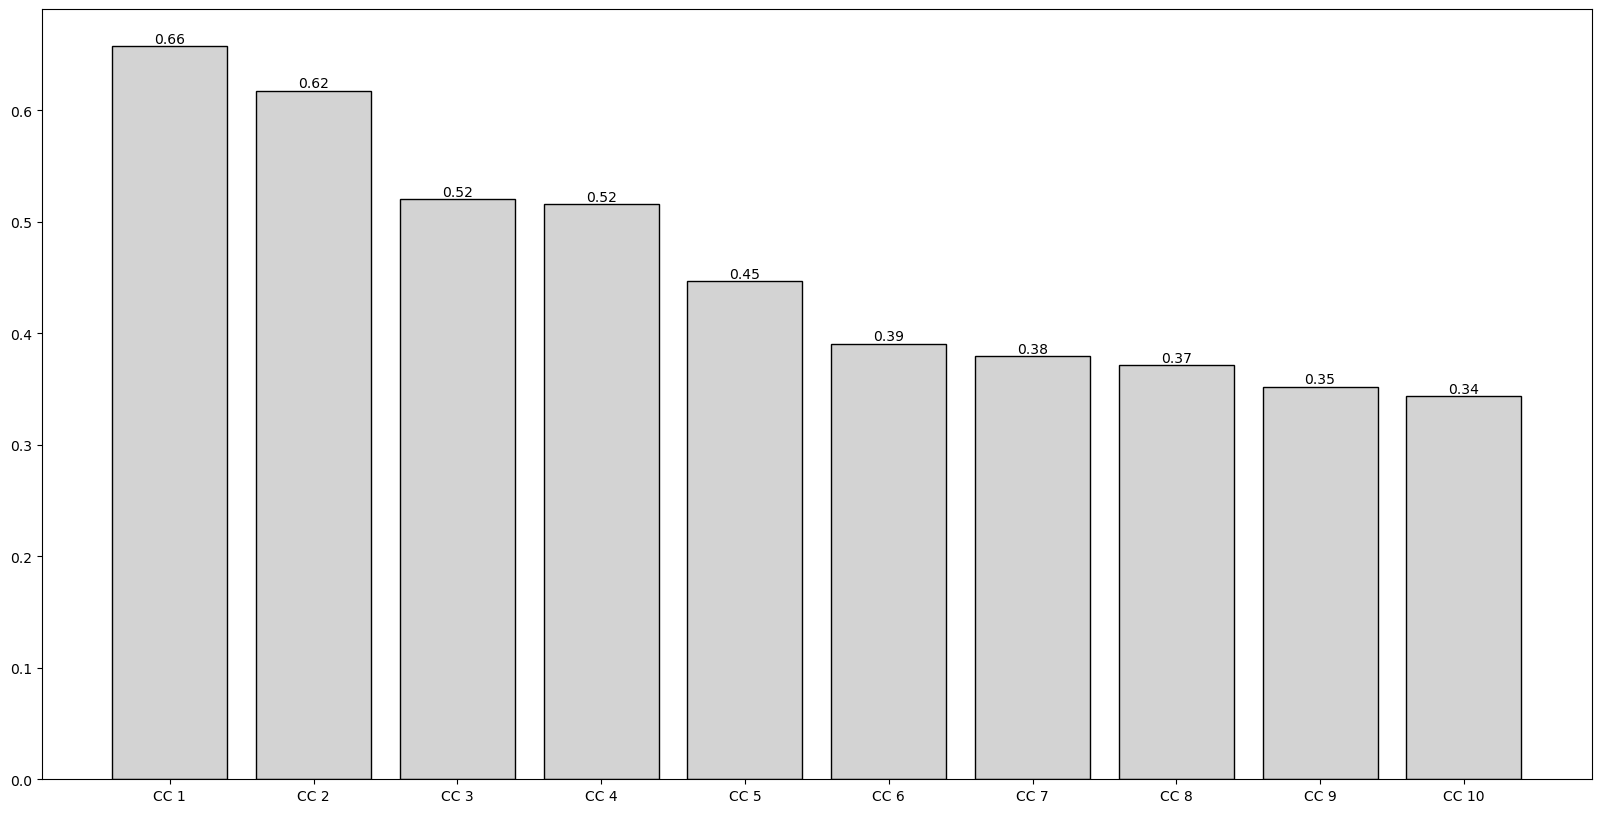

In [103]:
cca_no_lag.conduct_cca()

## with lags

In [ ]:
cca_lags = cca_class.CCAclass(X1=dec.x_var_lags, X2=dec.y_var_lags_reduced, lagging_included=True)

In [ ]:
dec.y_var_lags_reduced.shape

(35989, 341)

Training CCA, kernel = None, regularization = 0.0000, 10 components
Canonical Correlation Per Component Pair: [0.90533 0.81373 0.7871  0.69766 0.65816 0.6064  0.57298 0.56397 0.54365
 0.50985]
% Shared Variance: [0.81963 0.66216 0.61953 0.48673 0.43317 0.36772 0.32831 0.31807 0.29555
 0.25995]


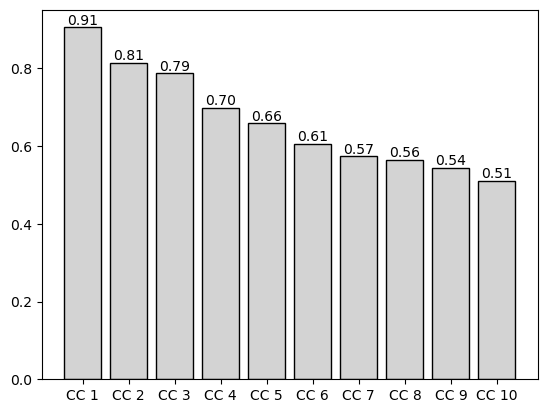

In [52]:
cca_lags.conduct_cca()

In [ ]:
gc.collect()

## compare lag vs no lag

In [105]:
canon_df = pd.DataFrame(cca_no_lag.canon_corr, columns = ['no_lag'])
canon_df[f'lag_{dec.max_lag_number}'] = cca_lags.canon_corr
canon_df['component'] = [f'CC {i+1}' for i in range(cca_lags.n_components)]
# convert canon_df to long format
canon_df_long = pd.melt(canon_df, id_vars=['component'], var_name='lag', value_name='canon_coeff')

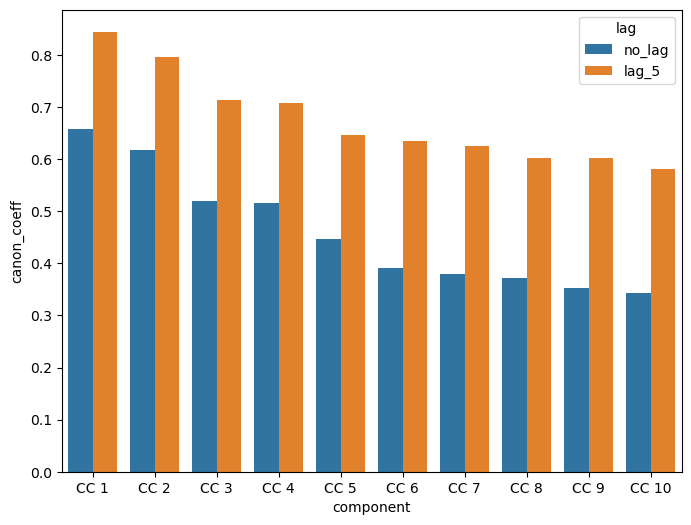

In [106]:
# make a sns bar plot on canon_df_long
plt.figure(figsize=(8, 6))
sns.barplot(x='component', y='canon_coeff', data=canon_df_long, hue='lag')
plt.show()

## cca_inst (choose one between lags and no lag)

In [55]:
# choose lags
cca_inst = cca_lags

In [ ]:
# choose no lag
cca_inst = cca_no_lag

## loadings

### neurons

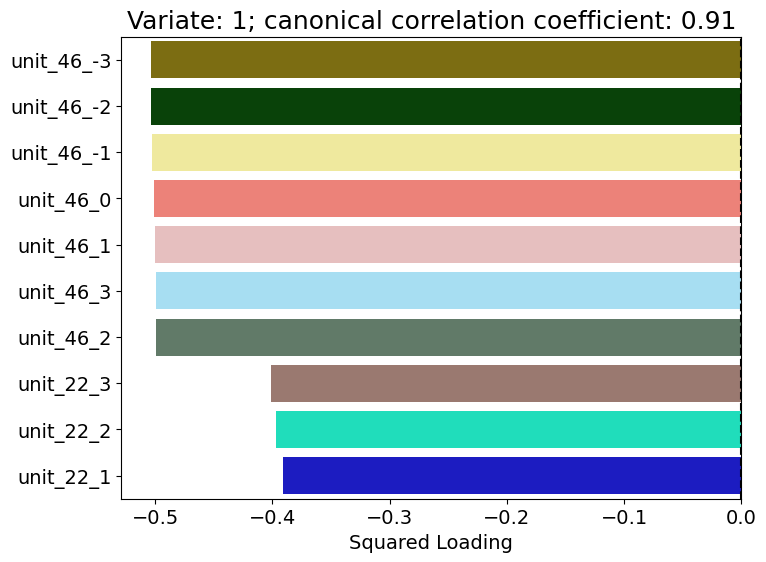

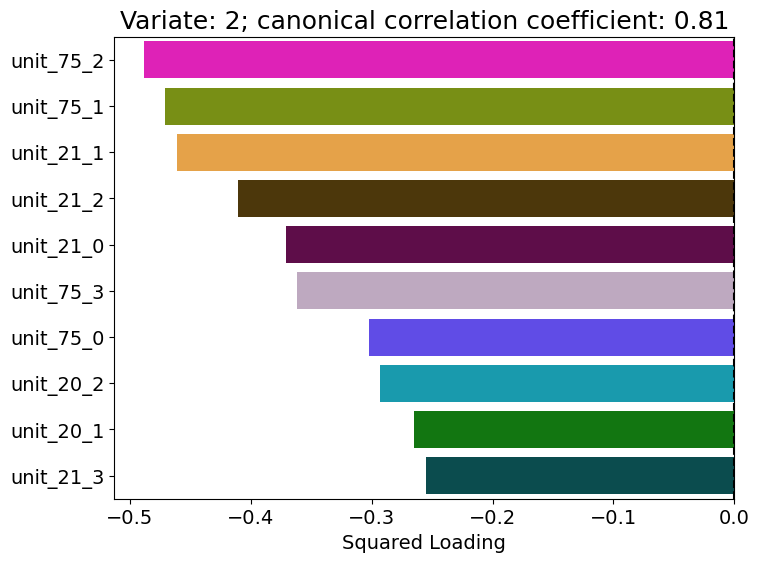

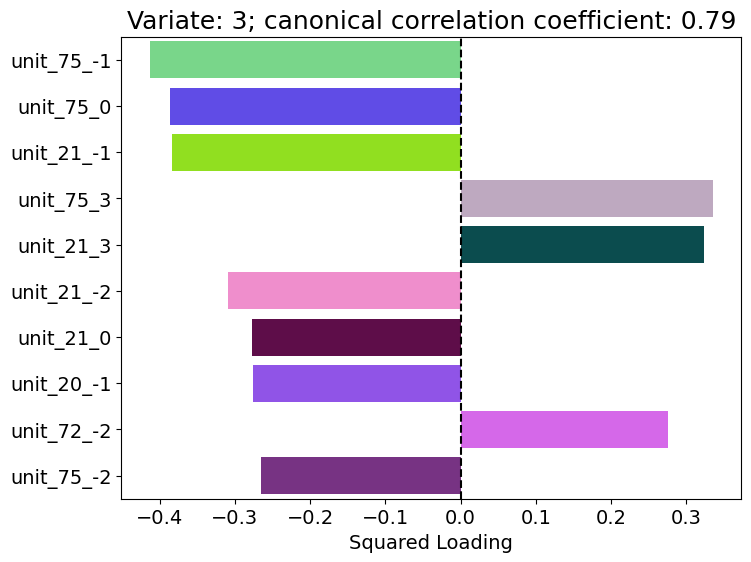

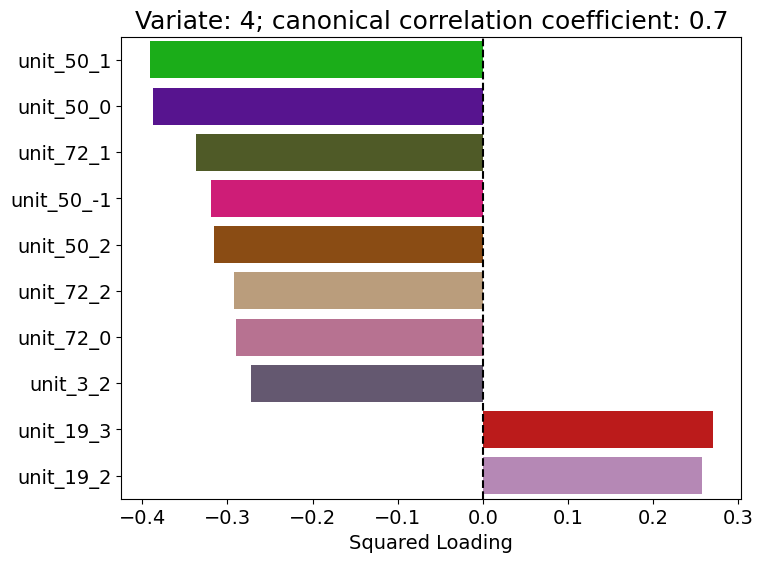

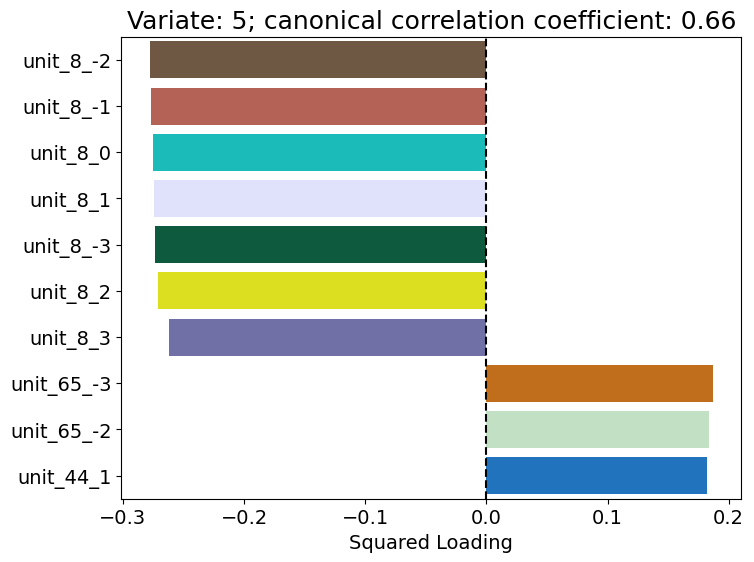

In [56]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1', squared=False)

### behavior

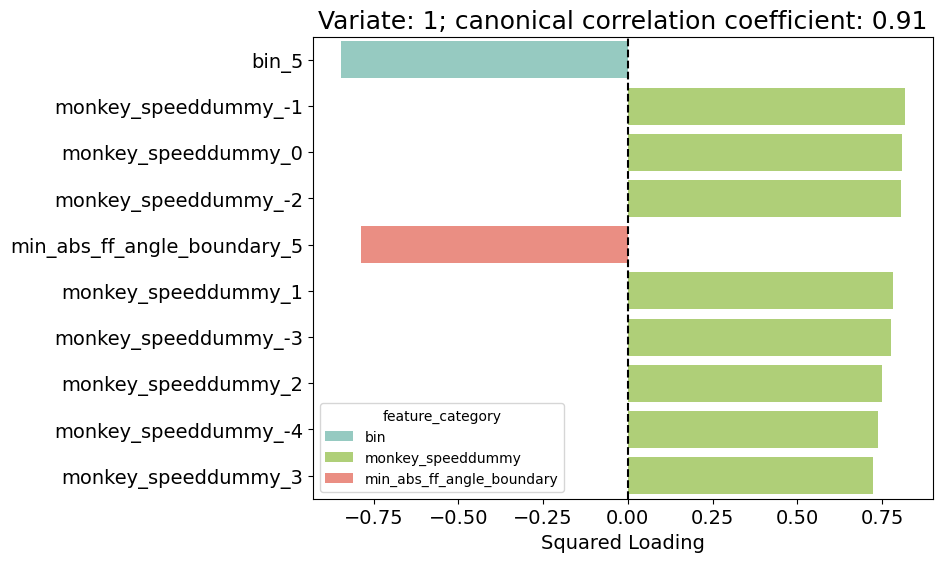

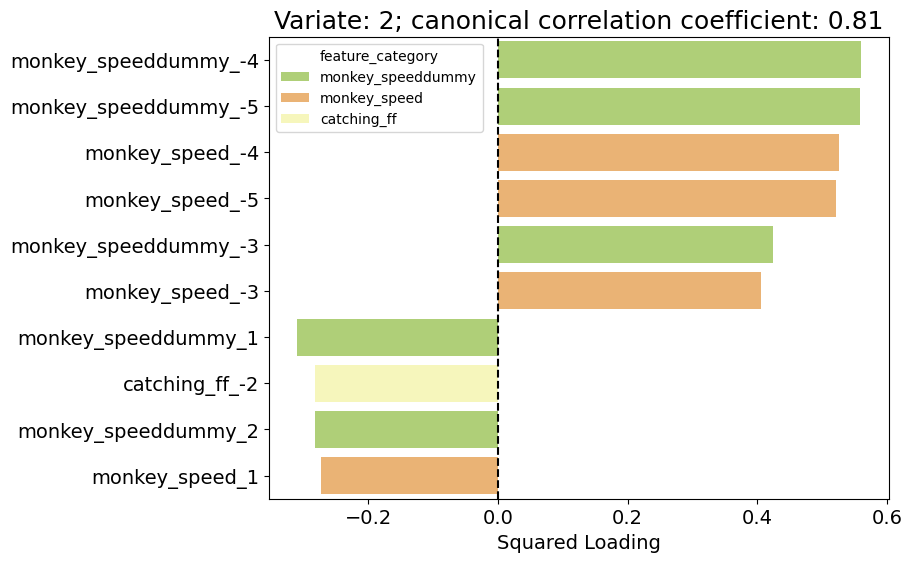

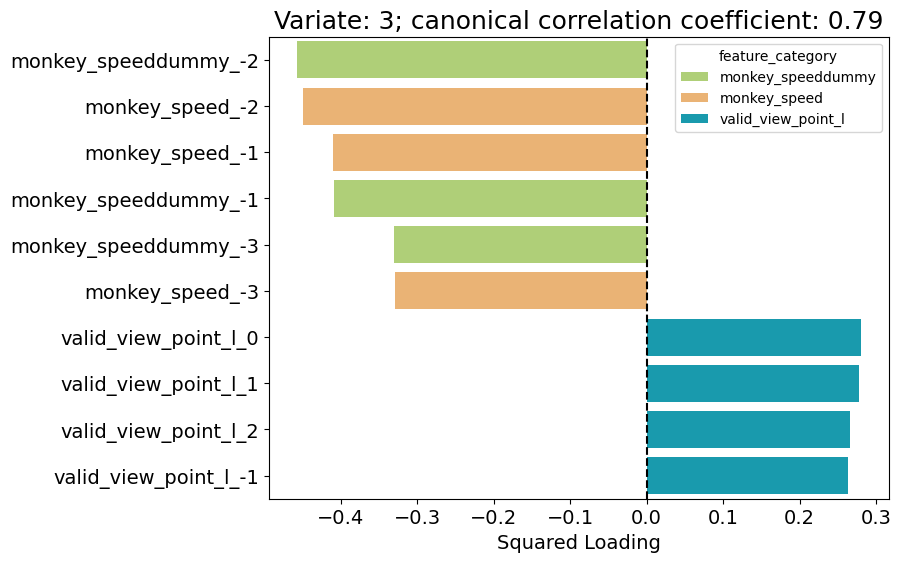

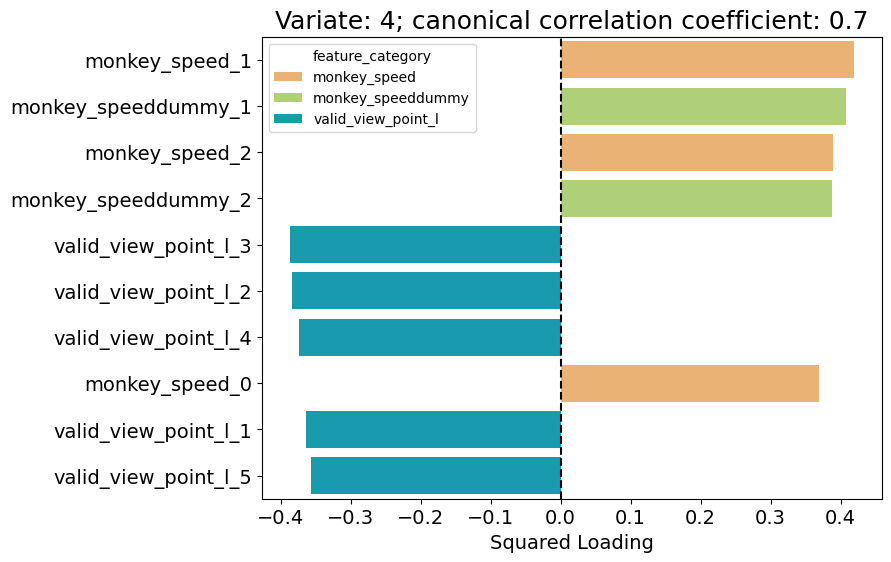

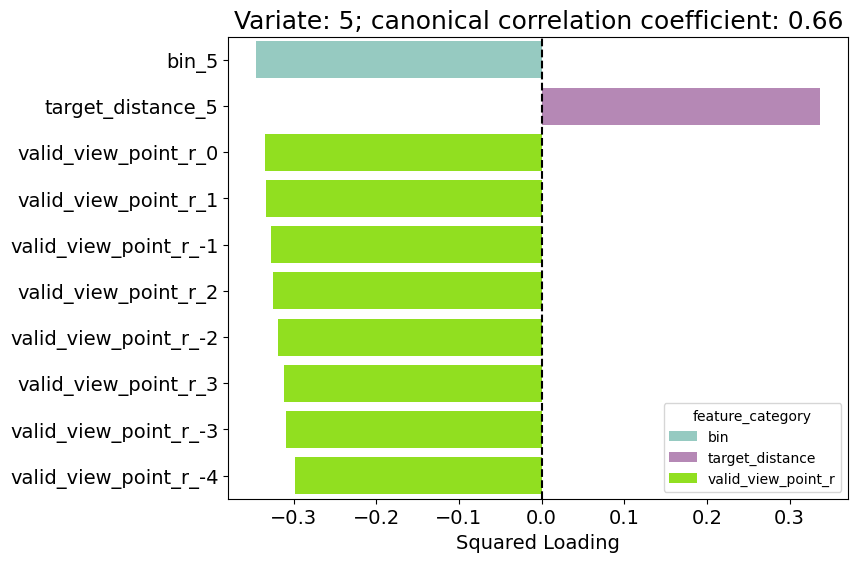

In [57]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2', squared=False)

## squared loadings

### neurons

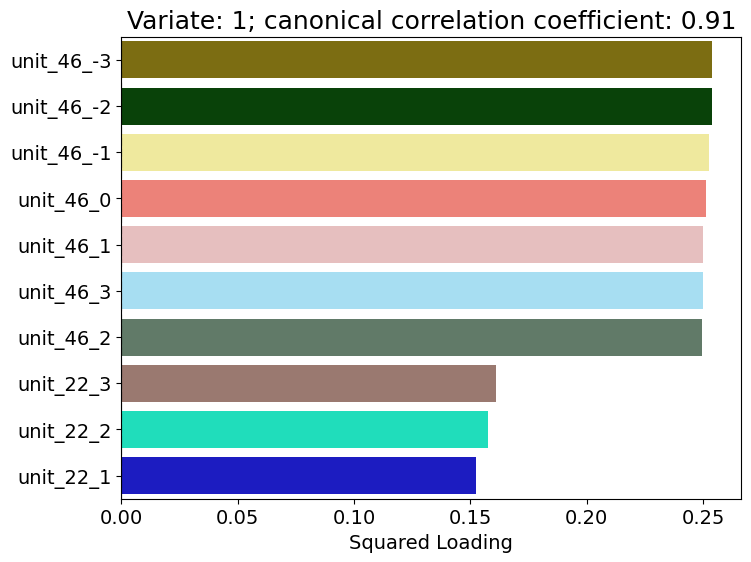

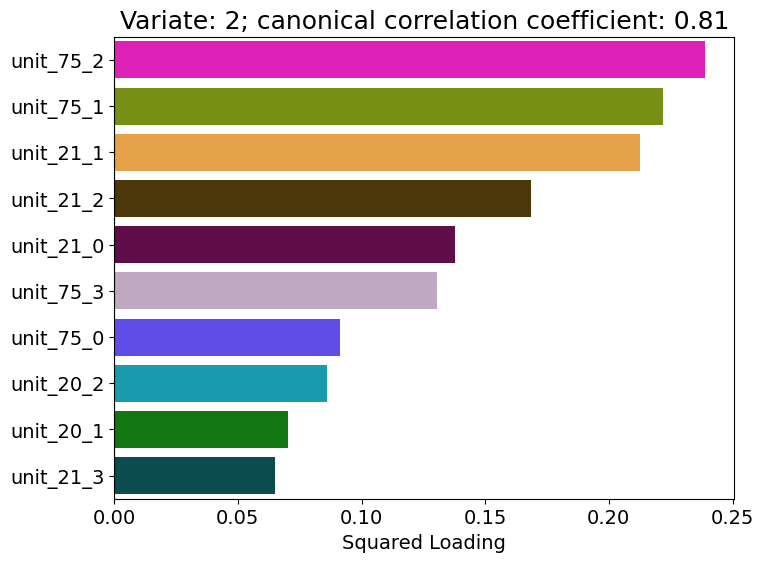

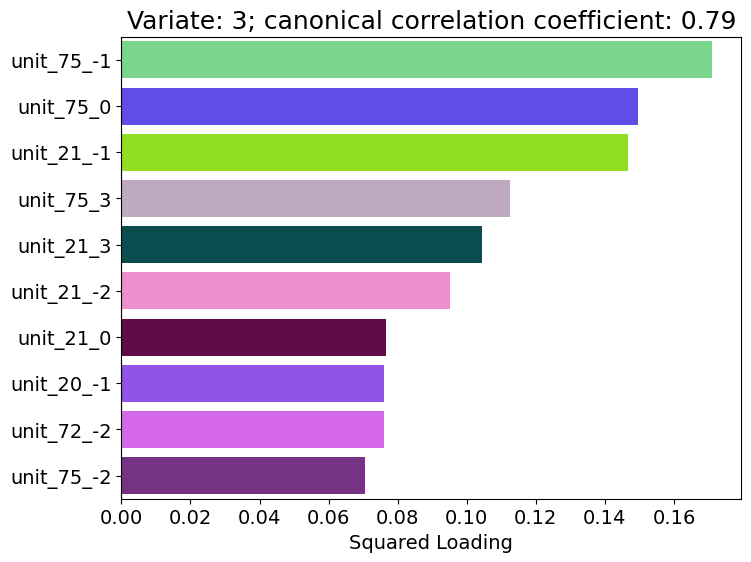

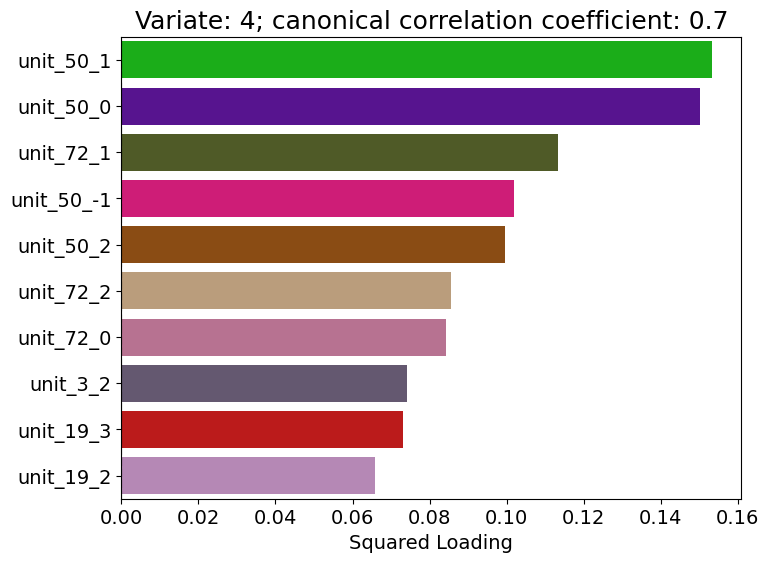

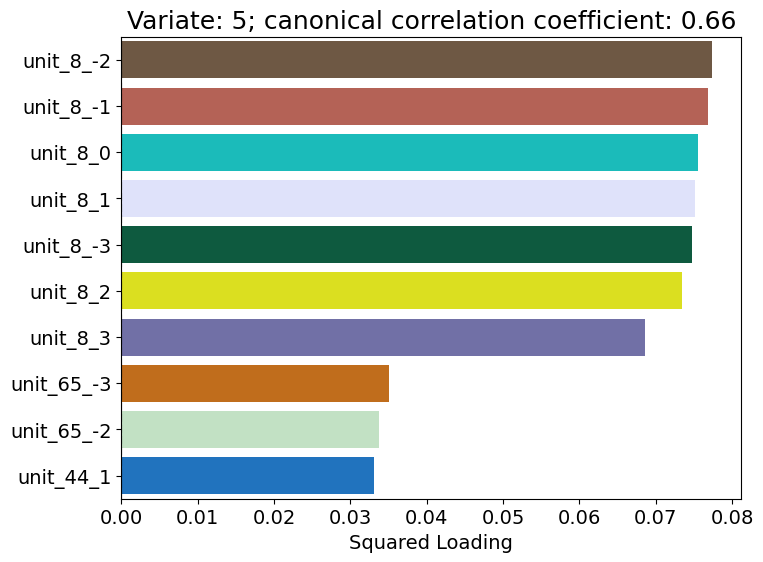

In [58]:
cca_inst.plot_ranked_loadings(X1_or_X2='X1')

### behavior

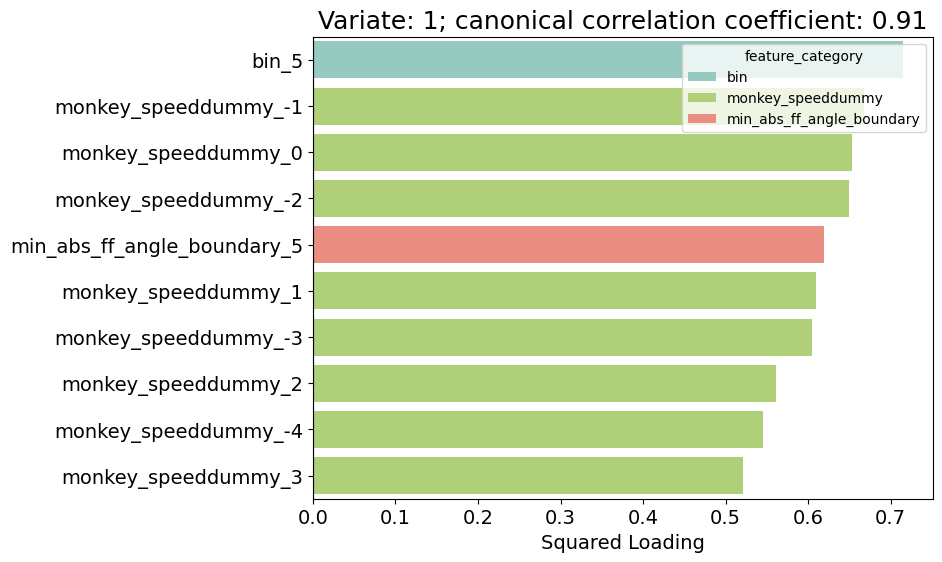

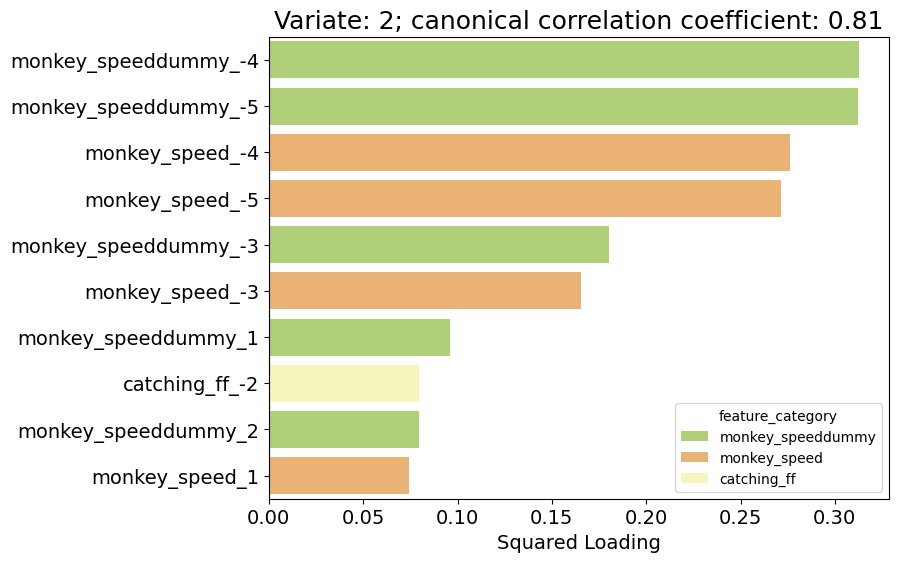

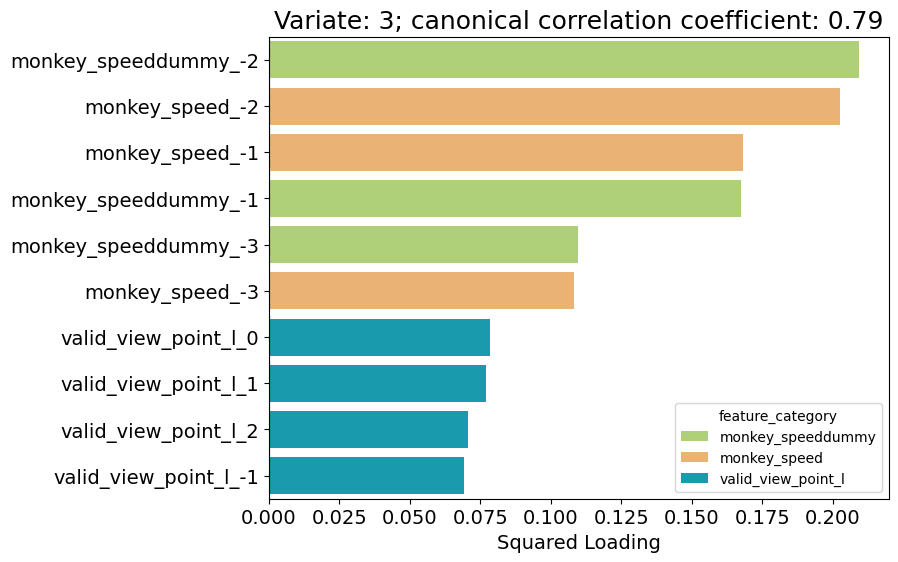

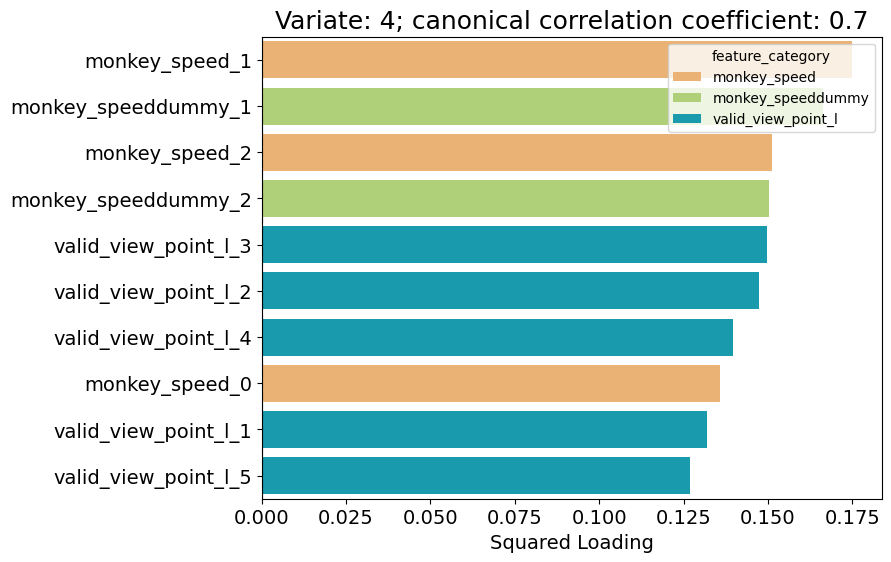

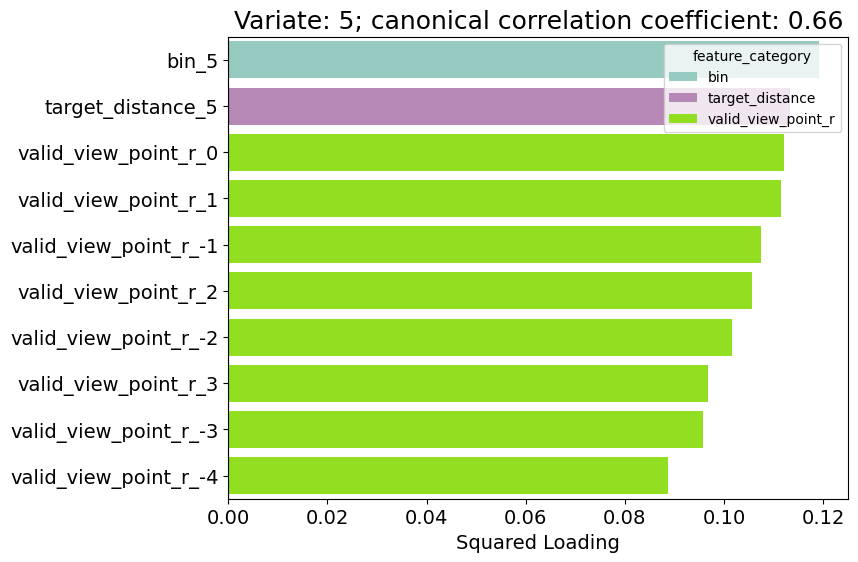

In [ ]:
cca_inst.plot_ranked_loadings(X1_or_X2='X2')

## abs weights ranked

### neurons

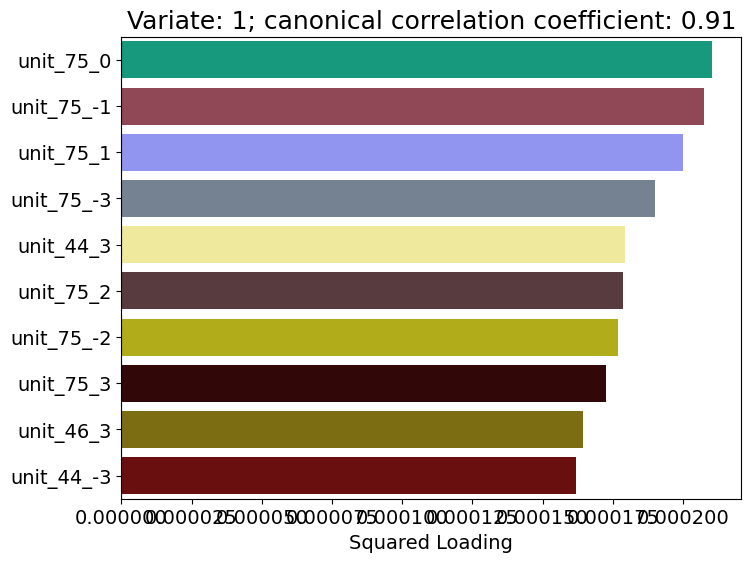

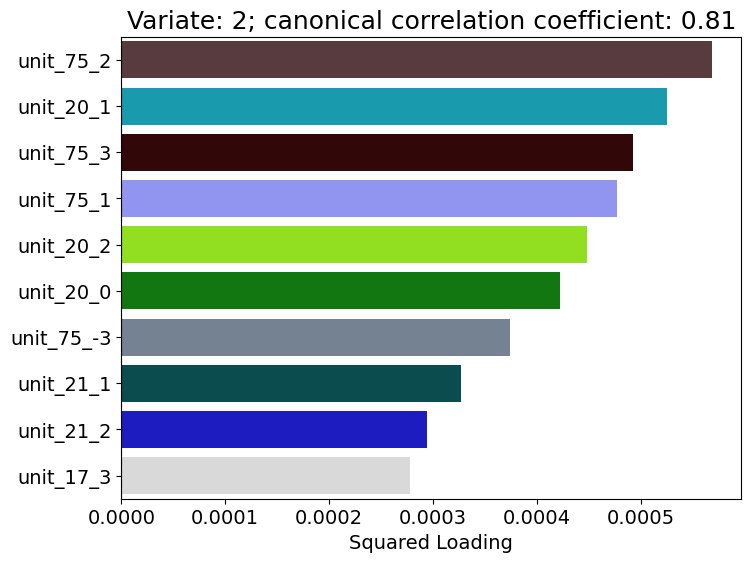

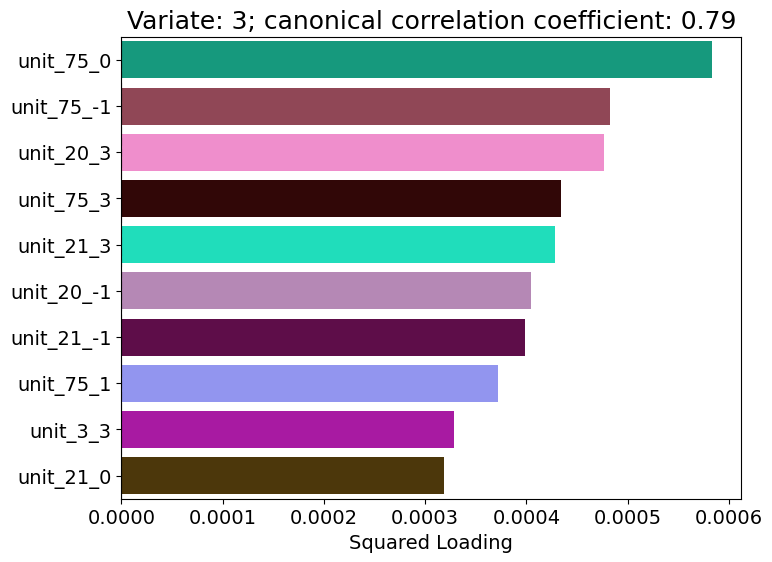

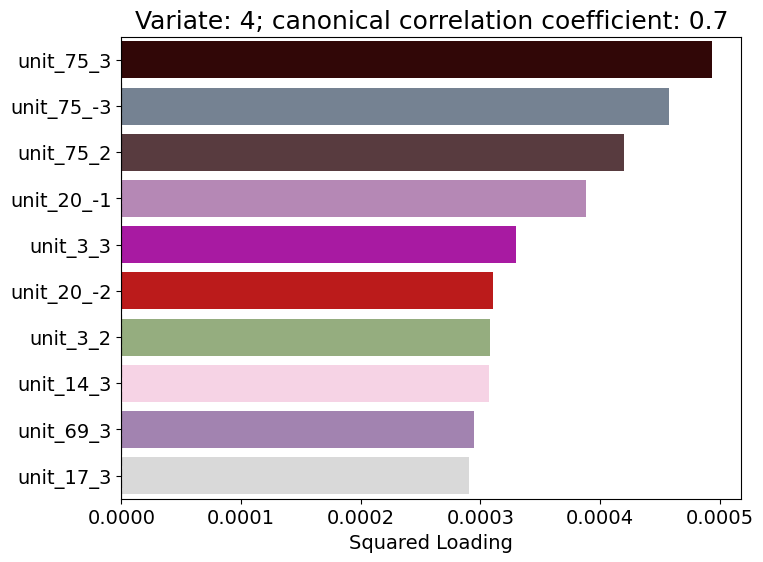

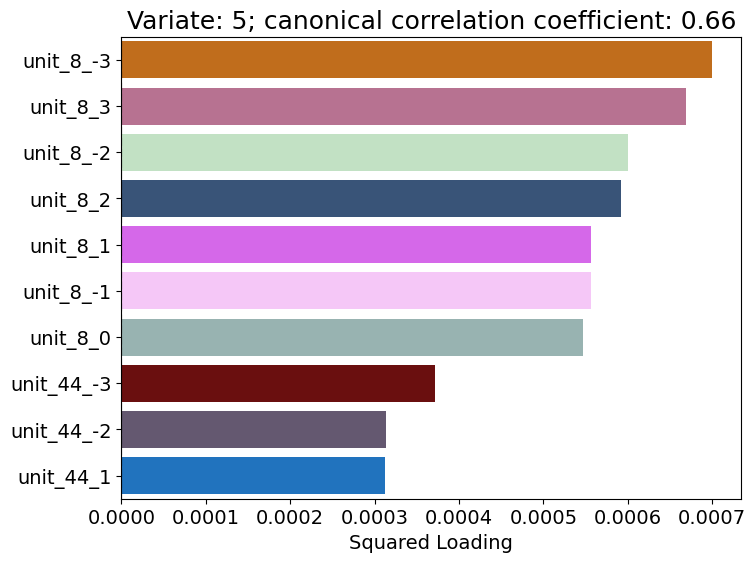

In [ ]:
cca_inst.plot_ranked_weights()

### behavior

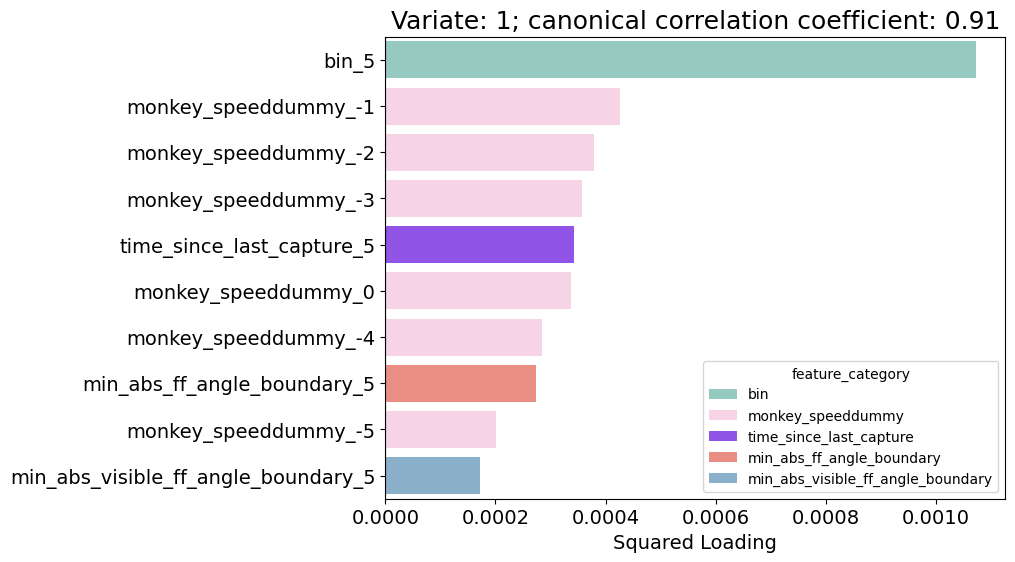

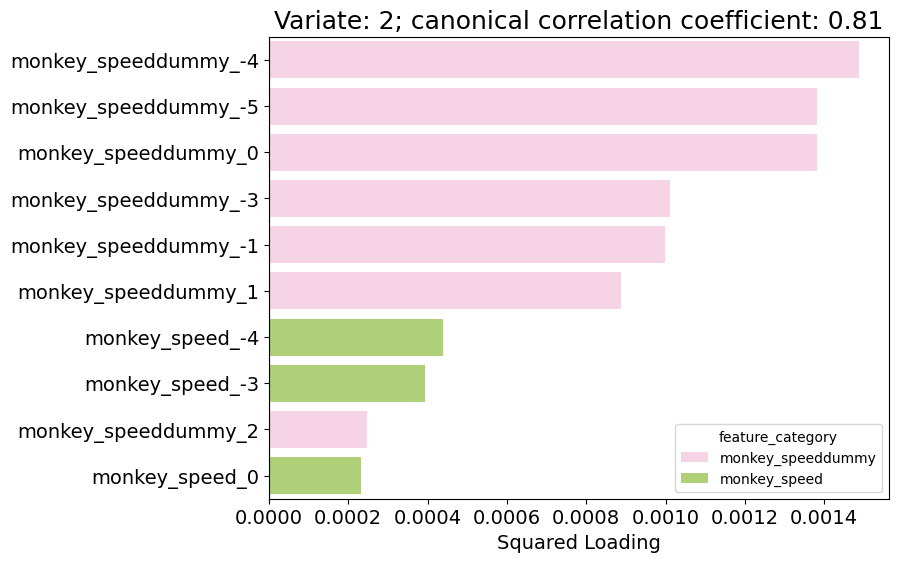

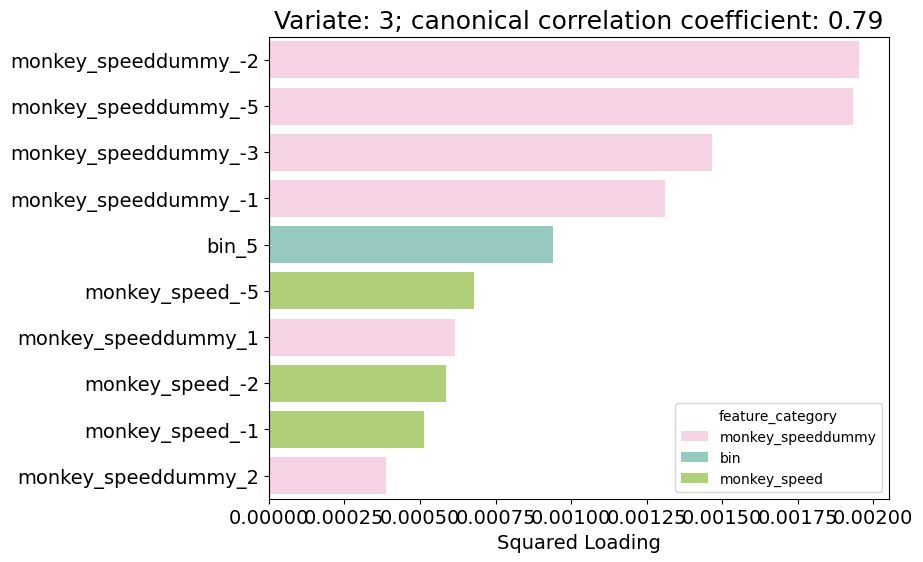

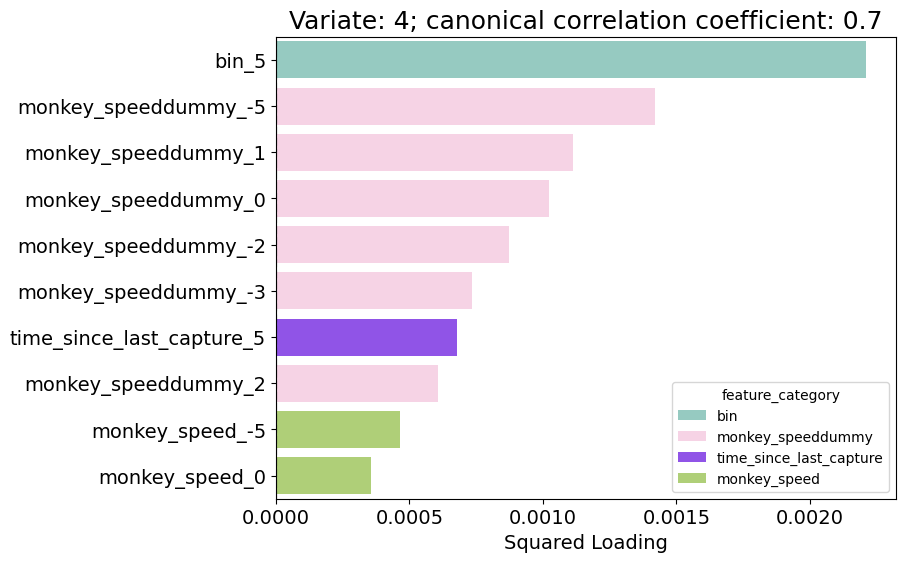

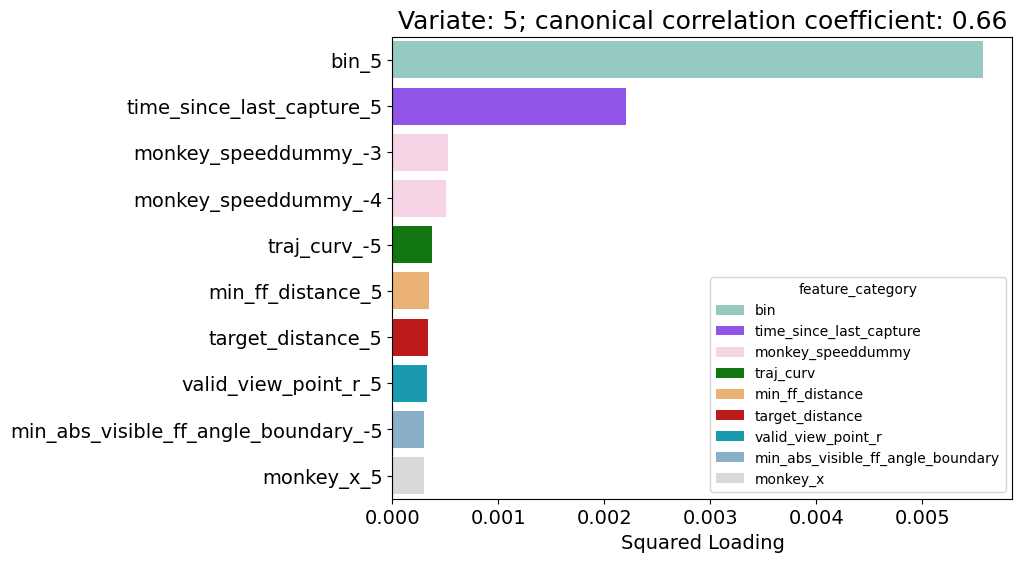

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2')

## plot real weights

### neurons

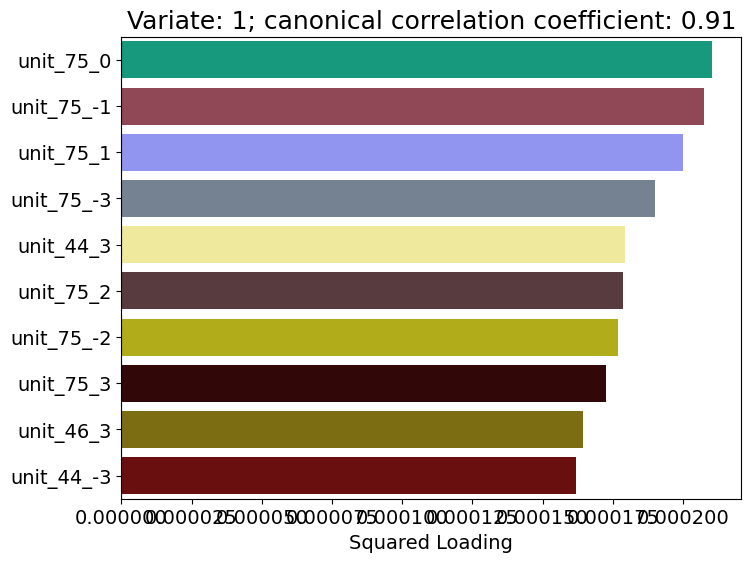

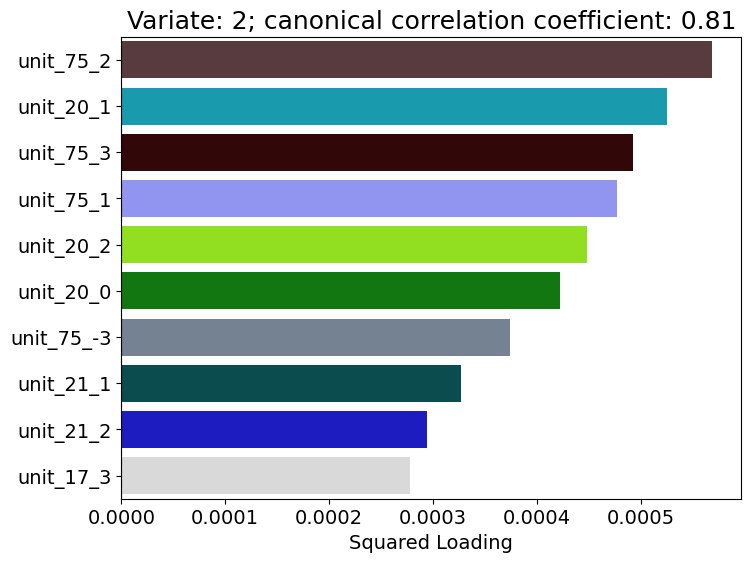

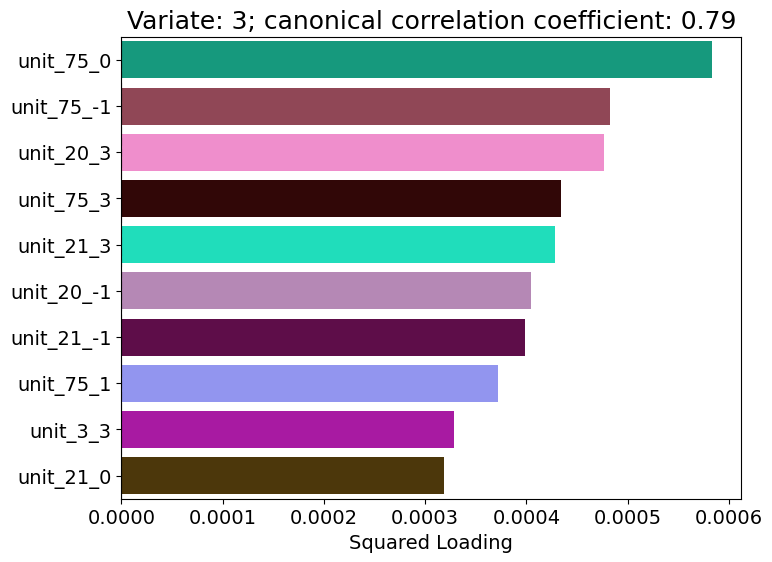

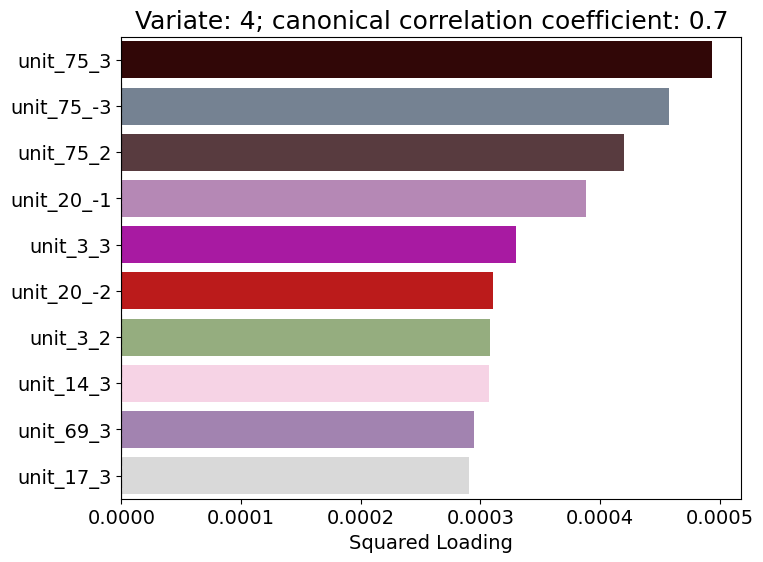

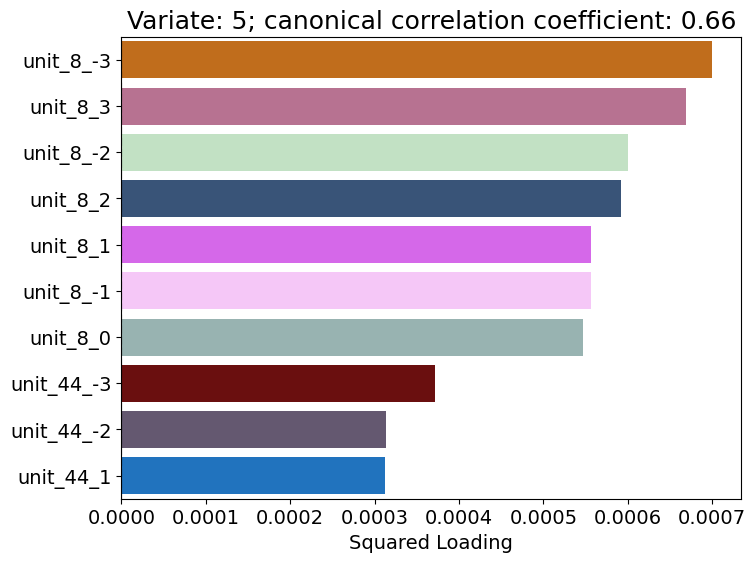

In [ ]:
cca_inst.plot_ranked_weights(abs_value=False)

### behavior

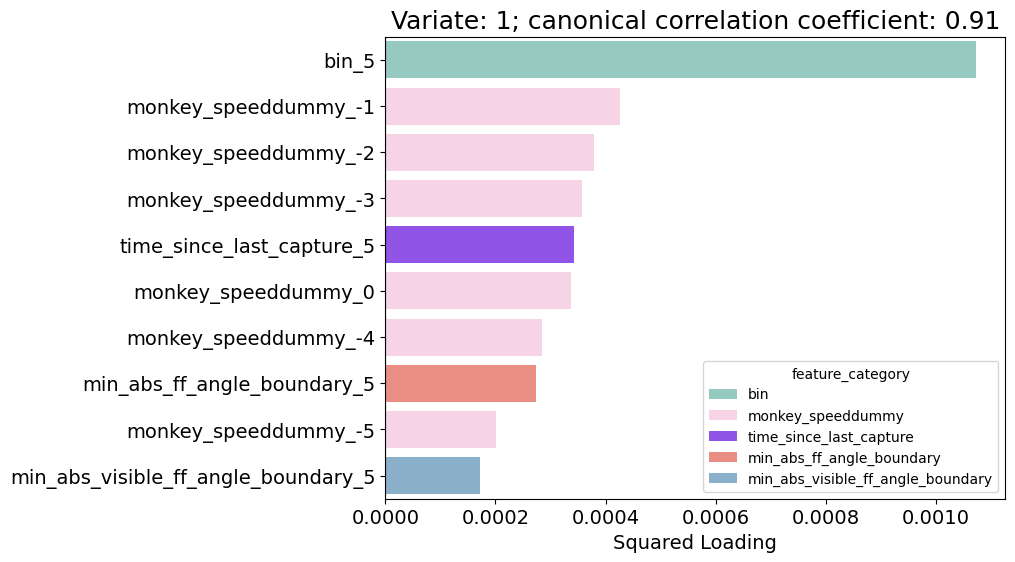

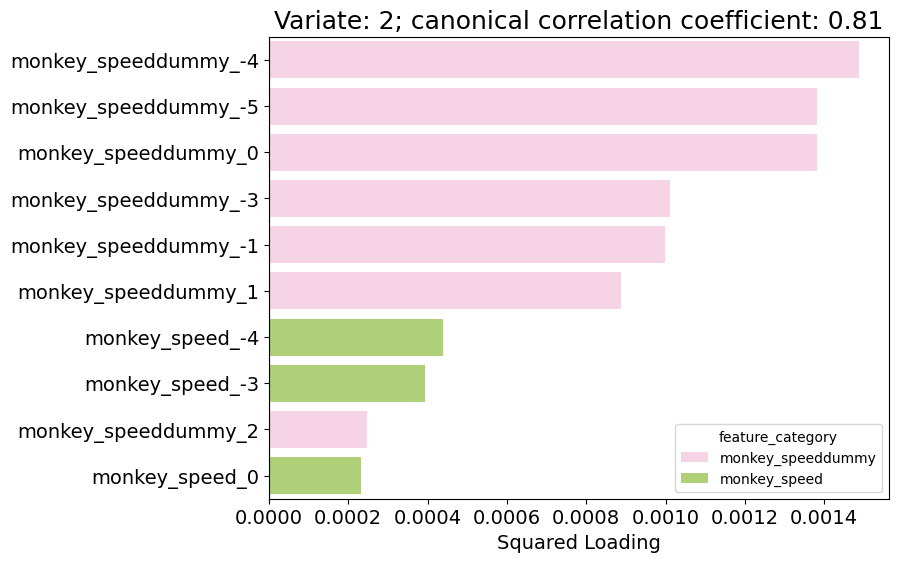

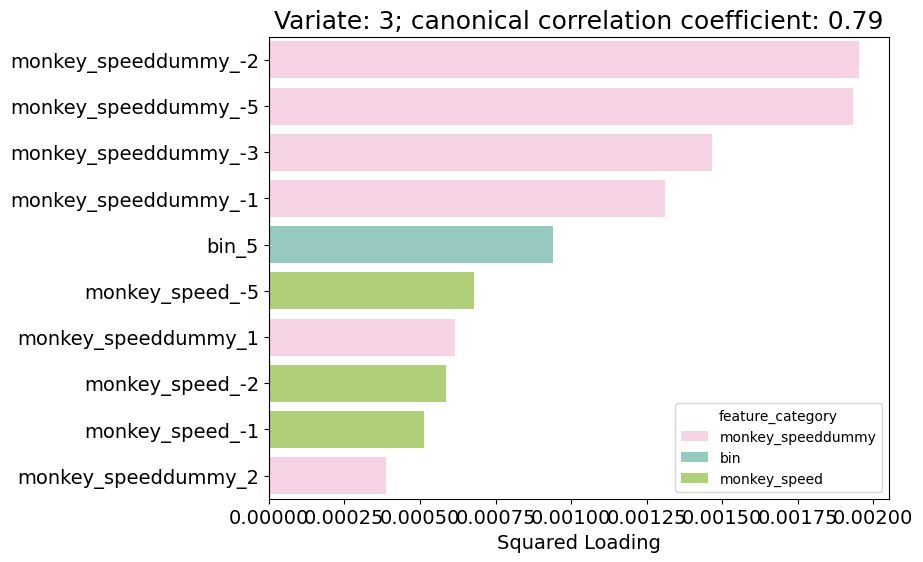

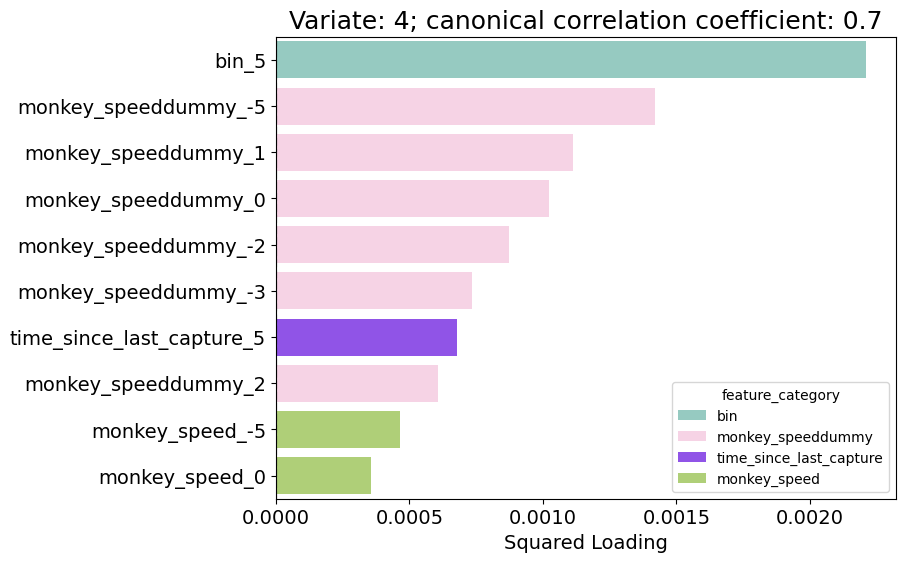

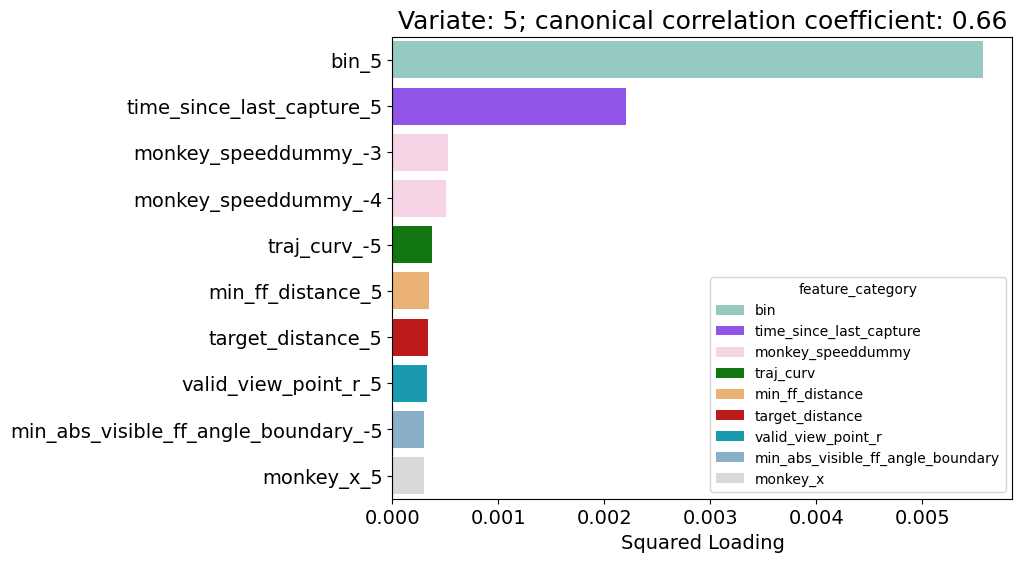

In [ ]:
cca_inst.plot_ranked_weights(X1_or_X2='X2', abs_value=False)

In [ ]:
stop here!

SyntaxError: invalid syntax (2745754519.py, line 1)

## distribution of each feature

In [124]:
cca_inst.X2_sc.shape

(2248, 391)

In [125]:
X2_sc_df = pd.DataFrame(cca_inst.X2_sc, columns = cca_inst.X2.columns)
X2_sc_df.describe()

,monkey_dw_0,monkey_ddw_0,monkey_ddv_0,monkey_speeddummy_0,whether_new_distinct_stop_0,delta_distance_0,LDz_0,RDz_0,gaze_mky_view_x_l_0,gaze_mky_view_y_l_0,gaze_mky_view_angle_l_0,gaze_mky_view_x_r_0,gaze_mky_view_y_r_0,gaze_mky_view_angle_r_0,eye_world_speed_0,valid_view_point_l_0,valid_view_point_r_0,num_visible_ff_0,min_visible_ff_distance_0,min_abs_visible_ff_angle_0,min_abs_visible_ff_angle_boundary_0,catching_ff_0,any_ff_visible_0,target_angle_0,target_angle_to_boundary_0,target_visible_dummy_0,target_opt_arc_dheading_0,gaze_world_x_l_0,gaze_world_y_l_0,gaze_world_x_r_0,gaze_world_y_r_0,monkey_dw_-1,monkey_ddw_-1,monkey_ddv_-1,monkey_speeddummy_-1,whether_new_distinct_stop_-1,delta_distance_-1,LDz_-1,RDz_-1,gaze_mky_view_x_l_-1,gaze_mky_view_y_l_-1,gaze_mky_view_angle_l_-1,gaze_mky_view_x_r_-1,gaze_mky_view_y_r_-1,gaze_mky_view_angle_r_-1,eye_world_speed_-1,valid_view_point_l_-1,valid_view_point_r_-1,num_visible_ff_-1,min_ff_distance_-1,...,gaze_world_x_l_-5,gaze_world_y_l_-5,gaze_world_x_r_-5,gaze_world_y_r_-5,target_x_-5,target_y_-5,bin_5,monkey_speed_5,monkey_angle_5,monkey_dw_5,monkey_ddw_5,monkey_ddv_5,monkey_speeddummy_5,whether_new_distinct_stop_5,delta_distance_5,LDz_5,RDz_5,gaze_mky_view_x_l_5,gaze_mky_view_y_l_5,gaze_mky_view_angle_l_5,gaze_mky_view_x_r_5,gaze_mky_view_y_r_5,gaze_mky_view_angle_r_5,eye_world_speed_5,valid_view_point_l_5,valid_view_point_r_5,num_alive_ff_5,num_visible_ff_5,min_ff_distance_5,min_abs_ff_angle_boundary_5,min_visible_ff_distance_5,min_abs_visible_ff_angle_boundary_5,catching_ff_5,any_ff_visible_5,target_distance_5,target_angle_5,target_angle_to_boundary_5,target_last_seen_time_5,target_last_seen_distance_frozen_5,target_last_seen_angle_to_boundary_frozen_5,target_visible_dummy_5,time_since_last_capture_5,traj_curv_5,target_opt_arc_dheading_5,gaze_world_x_l_5,gaze_world_y_l_5,gaze_world_x_r_5,gaze_world_y_r_5,target_x_5,target_y_5
count,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,...,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000,2248.00000
mean,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,...,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,-0.00000,-0.00000
std,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00022,1.00

In [ ]:
for column in X2_sc_df.columns:
    plt.figure(figsize=(8, 2))
    sns.boxplot(X2_sc_df[column], orient='h')
    plt.show()
    

## heatmap of weights
raw canonical coefficients are interpreted in a manner analogous to interpreting regression coefficients. For example: a one unit increase in reading leads to a .0446 decrease in the first canonical variate of set 2 when all of the other variables are held constant (in some other data)

In [ ]:
weight_df = cca_inst.X2_weight_df.copy()
weight_df = weight_df.set_index('feature').drop(columns='feature_category')

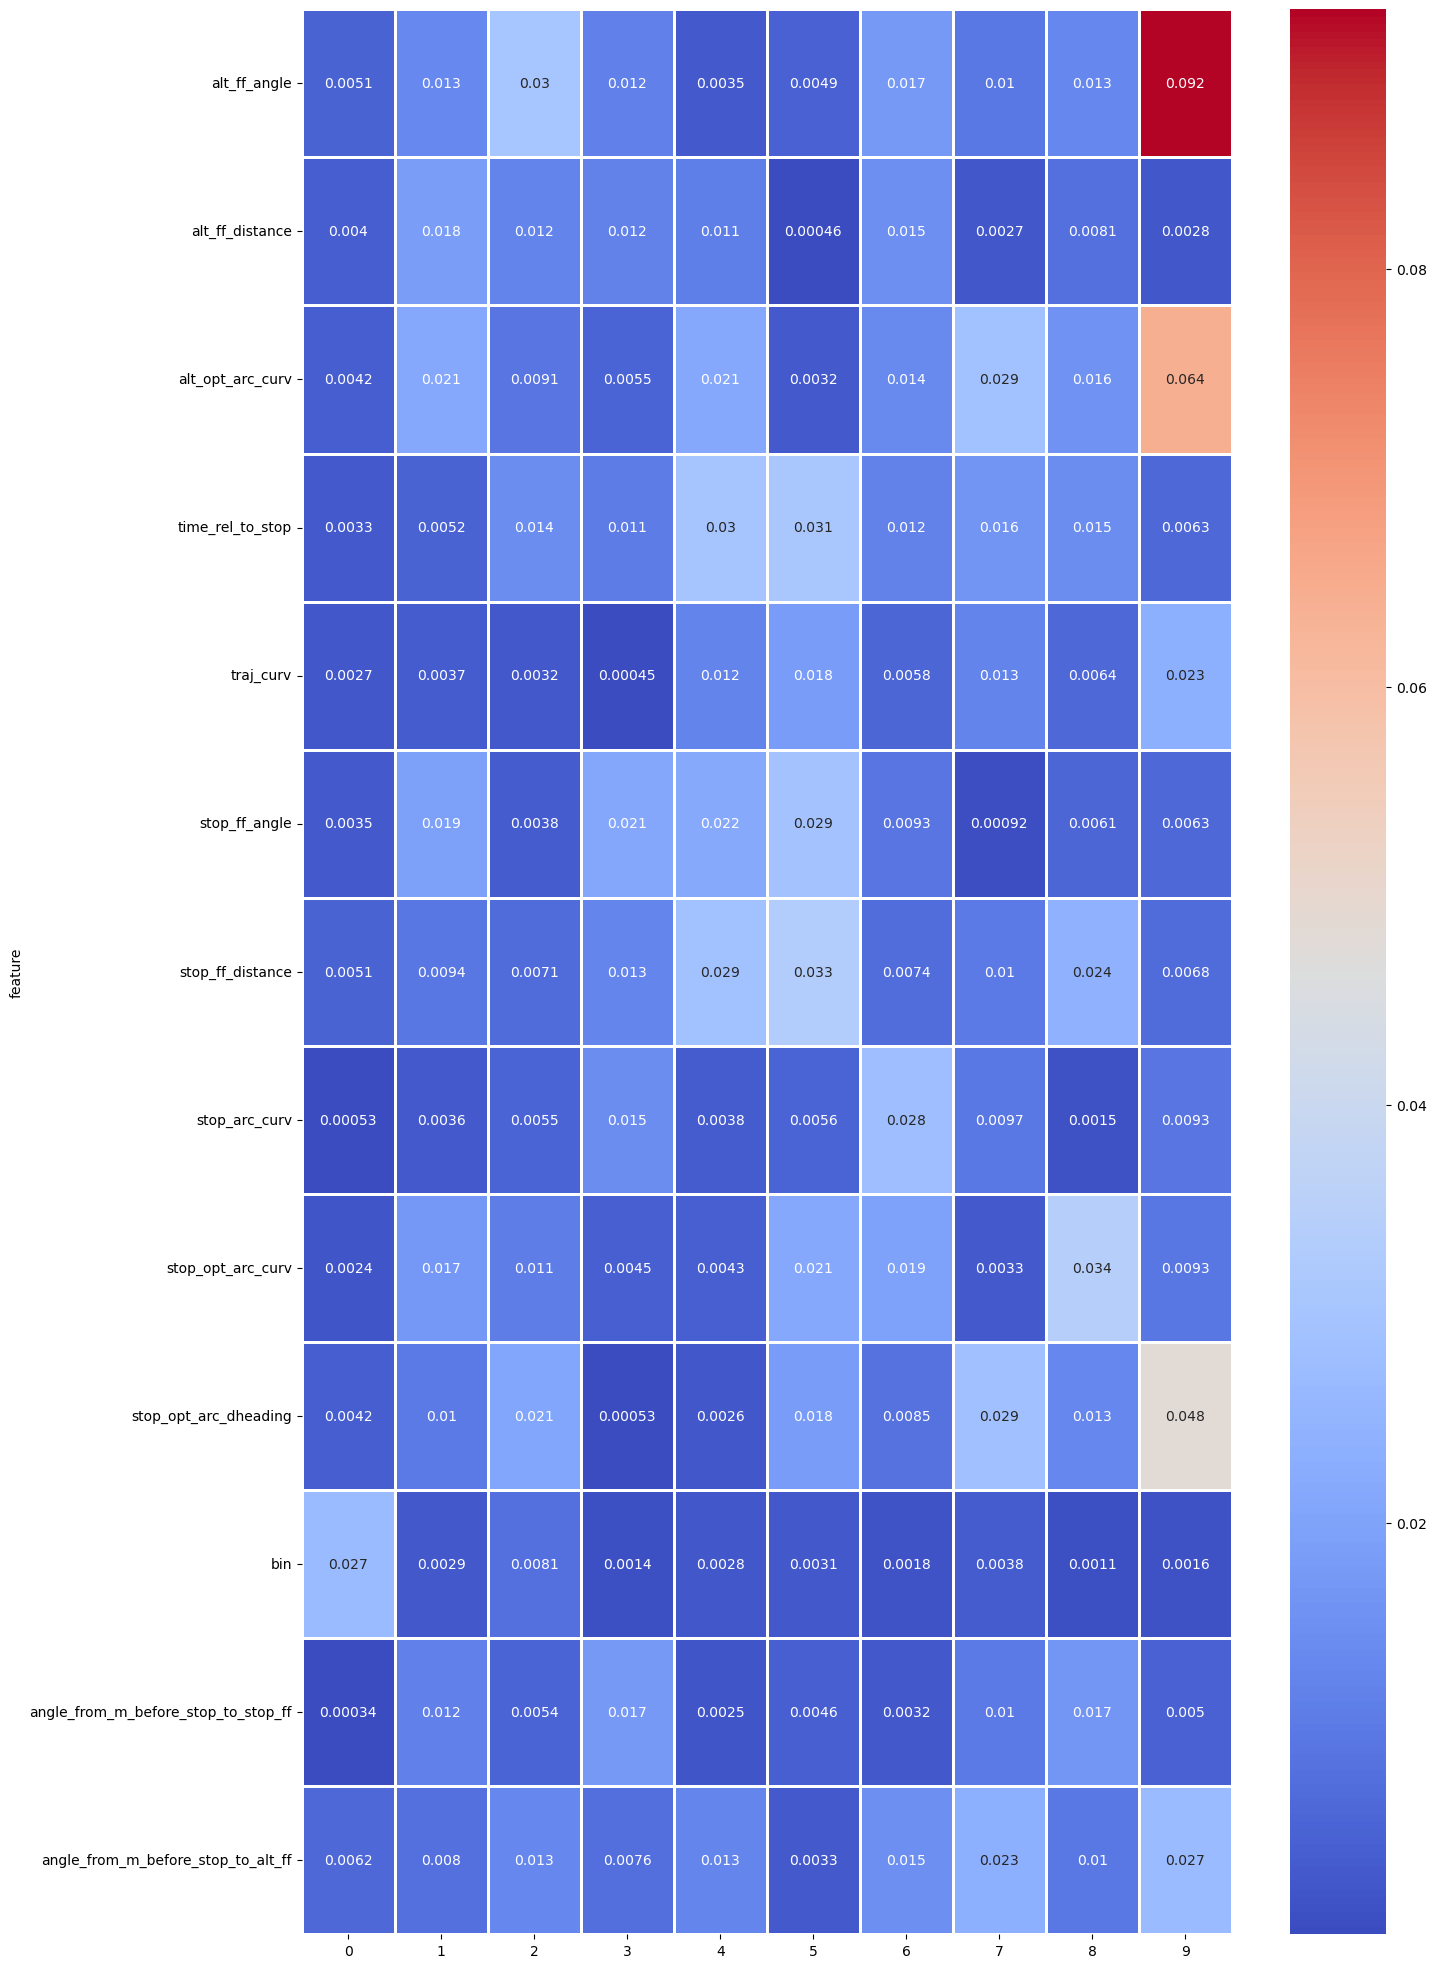

In [ ]:
plt.subplots(figsize=(15, 25))
sns.heatmap(weight_df.iloc[:20, :10], cmap='coolwarm', annot=True, linewidths=1)
plt.show()

## train test split

In [127]:
train1, test1, train2, test2 = train_test_split(cca_inst.X1_sc, cca_inst.X2_sc, test_size=0.3, random_state=42)
# use training and testing set
nComponents = 10
cca2 = rcca.CCA(kernelcca = False, reg = 0., numCC = nComponents)
cca2.train([train1, train2])
testcorrs = cca2.validate([test1, test2])
testcorrs

Training CCA, kernel = None, regularization = 0.0000, 10 components


[array([ 0.124  ,  0.08079,  0.08699,  0.07477,  0.05261,  0.07874,
         0.02287, -0.04017,  0.24821,  0.10086,  0.0928 ,  0.07143,
         0.06705,  0.03988,  0.21919,  0.05805,  0.07962,  0.19237,
        -0.02356,  0.04806,  0.22055,  0.41087,  0.1362 ,  0.08072,
         0.04401,  0.0494 ,  0.00523, -0.0073 ,  0.03426,  0.00749,
         0.09546,  0.03191,  0.10186,  0.05426,  0.03053,  0.01771,
        -0.04183, -0.00517, -0.0279 , -0.16953,  0.01005,  0.13365,
         0.05089,  0.03349,  0.2015 ,  0.076  ,  0.01865,  0.08615,
         0.01793,  0.07299,  0.17371, -0.02074,  0.04371,  0.09668,
         0.01634,  0.03671,  0.06105,  0.06829,  0.03836, -0.03274,
        -0.01849, -0.04834,  0.1697 ,  0.0432 ,  0.02303,  0.03473,
         0.05767,  0.06447,  0.02859,  0.14392,  0.01219, -0.00714,
         0.18142,  0.01571,  0.29139,  0.40978,  0.0267 ,  0.05221,
         0.03546,  0.00914,  0.03575,  0.09132, -0.01649,  0.12365,
         0.04227,  0.05179]),
 array([ 0.05355, 

## compute explained variance

In [128]:
cca2.compute_ev([test1, test2])

Computing explained variance for component #1
Computing explained variance for component #2
Computing explained variance for component #3
Computing explained variance for component #4
Computing explained variance for component #5
Computing explained variance for component #6
Computing explained variance for component #7
Computing explained variance for component #8
Computing explained variance for component #9
Computing explained variance for component #10


[array([[0.11728, 0.12545, 0.36682, 0.00077, 0.28112, 0.49004, 0.1963 ,
         0.18127, 0.22229, 0.23491, 0.28811, 0.10492, 0.1207 , 0.23423,
         0.06482, 0.13448, 0.12637, 0.31332, 0.27812, 0.16951, 0.03002,
         0.10739, 0.12084, 0.1208 , 0.10024, 0.49596, 0.1604 , 0.20414,
         0.23473, 0.60252, 0.2921 , 0.32474, 0.11336, 0.27368, 0.07812,
         0.20397, 0.20946, 0.24073, 0.29226, 0.15688, 0.11096, 0.0234 ,
         0.0033 , 0.25178, 0.08935, 0.4095 , 0.60393, 0.31937, 0.2348 ,
         0.20237, 0.02404, 0.39387, 0.26652, 0.25509, 0.19531, 0.52516,
         0.35546, 0.15173, 0.13763, 0.56382, 0.17625, 0.46358, 0.0052 ,
         0.26482, 0.03256, 0.13559, 0.06778, 0.18327, 0.20652, 0.05031,
         0.3577 , 0.43109, 0.11962, 0.22357, 0.17817, 0.13007, 0.42827,
         0.24694, 0.42862, 0.77101, 0.67547, 0.1552 , 0.40072, 0.36847,
         0.24471, 0.64975],
        [0.05037, 0.25619, 0.28548, 0.01645, 0.22217, 0.35662, 0.16937,
         0.18031, 0.22882, 0.17149, 

## test for p values

In [129]:
stats_cca = CanCorr(cca_inst.X1_sc, cca_inst.X2_sc)
print(stats_cca.corr_test().summary())
neural_data_modeling.print_weights('X', stats_cca.x_cancoef)
neural_data_modeling.print_weights('Z', stats_cca.y_cancoef)

                              Cancorr results
   Canonical Correlation Wilks' lambda   Num DF      Den DF   F Value Pr > F
----------------------------------------------------------------------------
0                 0.8447        0.0000 33626.0000 177465.2791  1.5594 0.0000
1                 0.7965        0.0000 33150.0000 175524.5186  1.4819 0.0000
2                 0.7142        0.0000 32676.0000 173580.6460  1.4229 0.0000
3                 0.7077        0.0000 32204.0000 171633.6602  1.3870 0.0000
4                 0.6461        0.0000 31734.0000 169683.5602  1.3516 0.0000
5                 0.6347        0.0000 31266.0000 167730.3455  1.3284 0.0000
6                 0.6255        0.0000 30800.0000 165774.0159  1.3066 0.0000
7                 0.6027        0.0000 30336.0000 163814.5713  1.2857 0.0000
8                 0.6023        0.0000 29874.0000 161852.0119  1.2682 0.0000
9                 0.5805        0.0000 29414.0000 159886.3384  1.2501 0.0000
10                0.5763      

# PGAM (unfinished)

In [ ]:
## Categorize variables
dec.y_var_reduced.columns
temporal_vars = ['time_rel_to_stop',
 'time_when_nxt_ff_first_seen_rel_to_stop',
 'time_when_cur_ff_first_seen_rel_to_stop',
 'time_when_nxt_ff_last_seen_rel_to_stop',
 'time_when_cur_ff_last_seen_rel_to_stop',
 ]

spatial_vars = [x for x in dec.y_var_reduced.columns if x not in temporal_vars]
spatial_vars

# Inspect data

## sparsity of neural data

In [ ]:
dec.binned_spikes_df.shape

(35989, 87)

In [ ]:
# inspect neural data

bins = dec.binned_spikes_df

# Calculate percentage of non-zero rows for each column
non_zero_percentages = (bins != 0).mean() * 100

# Create a DataFrame with the results
non_zero_df = pd.DataFrame({
    'Column': non_zero_percentages.index,
    'Percent_Non_Zero': non_zero_percentages.values
})

# Sort by percentage in descending order
non_zero_df = non_zero_df.sort_values('Percent_Non_Zero', ascending=False)

print("Percentage of non-zero values in each column:")
print(non_zero_df)


Percentage of non-zero values in each column:
     Column  Percent_Non_Zero
86      bin          99.99722
69  unit_69          89.96638
3    unit_3          81.69996
42  unit_42          80.49404
12  unit_12          79.49096
34  unit_34          73.74198
44  unit_44          71.86362
23  unit_23          68.72378
60  unit_60          68.10136
57  unit_57          61.60493
49  unit_49          60.36289
32  unit_32          59.07916
50  unit_50          56.61730
0    unit_0          56.52283
11  unit_11          55.95877
24  unit_24          55.93931
10  unit_10          55.80038
1    unit_1          55.63922
20  unit_20          54.55834
58  unit_58          53.04399
28  unit_28          51.87696
72  unit_72          51.69079
18  unit_18          50.72661
64  unit_64          48.49259
81  unit_81          47.96188
75  unit_75          45.94182
65  unit_65          44.65253
41  unit_41          44.15238
19  unit_19          43.25766
14  unit_14          42.12676
30  unit_30          41.

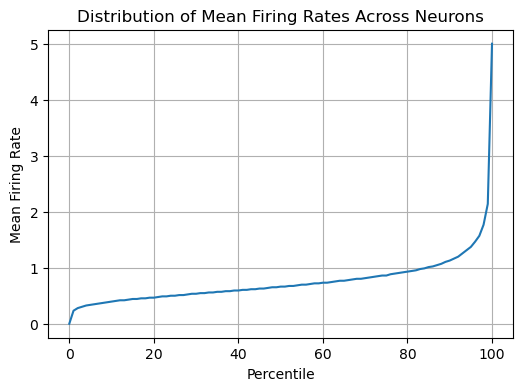

In [ ]:
bins.drop(columns='bin').mean(axis=1).describe()

# plot the percentile of values of mean firing rates across neurons at each time bin
mean_rates = bins.drop(columns='bin').mean(axis=1)

# Calculate percentiles from 0 to 100
percentiles = np.arange(0, 101, 1)
percentile_values = np.percentile(mean_rates, percentiles)

# Create plot
plt.figure(figsize=(6, 4))
plt.plot(percentiles, percentile_values)
plt.xlabel('Percentile')
plt.ylabel('Mean Firing Rate')
plt.title('Distribution of Mean Firing Rates Across Neurons')
plt.grid(True)
plt.show()


## multicollinearity

### y var (behavioral)

0 out of 54 features are processed for VIF.
10 out of 54 features are processed for VIF.
20 out of 54 features are processed for VIF.
30 out of 54 features are processed for VIF.
40 out of 54 features are processed for VIF.
50 out of 54 features are processed for VIF.
                  feature              vif
43                   time 4793712724.60000
0                     bin 4792496083.80000
51           target_index        639.90000
46           cum_distance        422.10000
15  gaze_mky_view_angle_l        234.00000
9                     LDy        229.90000
53               target_y        146.40000
45               monkey_y        141.00000


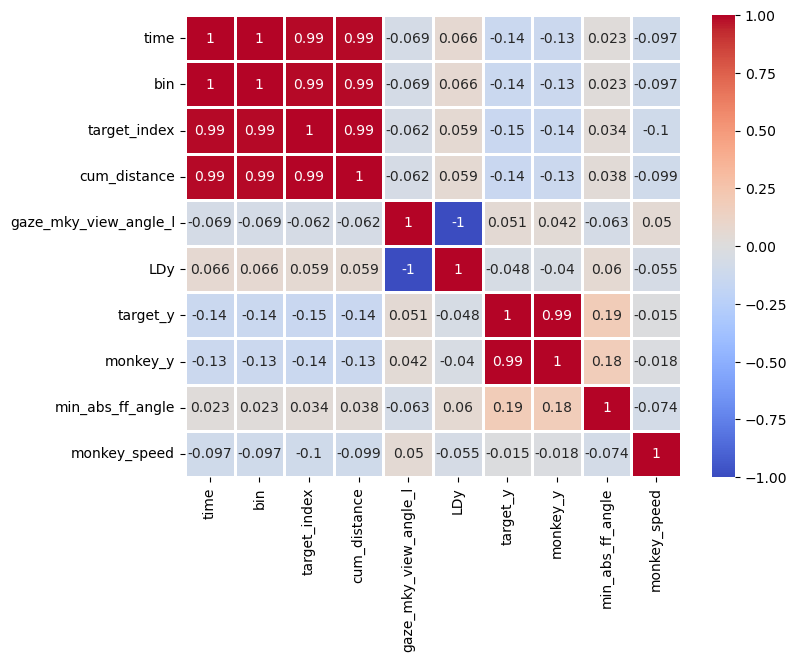

In [ ]:
y_var_vif = drop_high_vif_vars.get_vif_df(dec.y_var)
print(y_var_vif.head(8))

# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif_df[vif_df['vif'] > 5].feature.values
specific_columns = y_var_vif.feature.values[:10]
corr_coeff = dec.y_var[specific_columns].corr()
#plt.figure(figsize = (6, 6))
plt.figure(figsize = (8, 6))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

In [ ]:
# Try y_var_reduced

y_var_vif = drop_high_vif_vars.get_vif_df(dec.y_var_reduced)
print(y_var_vif.head(8))

# calculate the correlation coefficient among the columns with VIF > 5
# specific_columns = vif_df[vif_df['vif'] > 5].feature.values
specific_columns = y_var_vif.feature.values[:10]
corr_coeff = dec.y_var[specific_columns].corr()
#plt.figure(figsize = (6, 6))
plt.figure(figsize = (8, 6))
sns.heatmap(corr_coeff, cmap='coolwarm', annot=True, linewidths=1, vmin=-1)
plt.show()

# Appendix

## more columns (possibly get in the future)

get also get: (but to be honest, it doesn't make that much sense to get them....so let's skip for now.)
'distance traversed since target last visible',
'd angle since target last visible', 'target_at_right',
'time_till_capture', 'time from last visible to capture

Note that there might be multicollinearity. For example, duration from last visible to capture = time since target last visible + time till capture

Similarly, target angle = target angle last seen frozen - d angle since target last visible

(For distance it's not exactly the same because of the difference between distance and distance traversed, but it's still similar)

The multicollinearity is fine in linear regression (when each feature here is a y var), but need to be dealt with in cca.

## other thoughts

should i actually align each section, as if they are trials???
maybe i can try both that and continuous time... both can shed light on different behavioral variables
but for aligning trials, it may require alignment or warping since trial durations vary.

btw, what does it mean stitch data?

also, what does it look like to use RNN to model it?
I thought about the paper that Noah presented on


btw.......IME

## why ratio of bin/target_index approaches constant

In [ ]:
trial_lengths = dec.pursuit_data[['target_index', 'bin']].groupby('target_index').count()
trial_lengths.describe()

In [ ]:
sub = dec.y_var_reduced[['time', 'bin', 'target_index']]
sub['factor'] = dec.y_var_reduced['bin']/dec.y_var_reduced['target_index']
sub

In [ ]:
plt.hist(np.diff(dec.ff_caught_T_sorted), bins=30)
plt.xlabel('Time difference')
plt.ylabel('Count')
plt.title('Distribution of time differences between caught events')
plt.show()


In [ ]:
dec.ff_caught_T_sorted/np.arange(len(dec.ff_caught_T_sorted))